## In this notebook I aim to change the noise input of the generator to a low resolution galaxy image instead

By Shooby, started: July 25 <br>
last edited: Aug 18th

In [17]:
from __future__ import print_function
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.functional as F
from photutils import create_matching_kernel


from astropy.convolution import convolve_fft as convolve
import astropy.io.fits as pyfits
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

import warnings
warnings.filterwarnings('ignore')

In [18]:
# initializing parameters:

dataroot='gals/'
device = torch.device("cuda:0") # If GPU then use "cuda:0"
ngpu = 3 #number of GPUs to use 
ngf = 64
ndf = 64
workers = 8 #number of data loading workers
batchSize = 64 #input batch size
imageSize = 64 #the height / width of the input image to network
nz = 16 #size of the latent z vector
niter = 100 #number of epochs to train for
lr = 0.0002 #learning rate, default=0.0002
beta1 = 0.5 #beta1 for adam. default=0.5
outf='outputs' #folder to output images and model checkpoints
print(nz)

manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


16
Random Seed:  6812


In [19]:
dataset = dset.MNIST(root=dataroot, download=True,
                     transform=transforms.Compose([transforms.Resize(imageSize),transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,)),]))
nc=1

assert dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=True, num_workers=int(workers))


(41, 41)
(41, 41)
(41, 41)


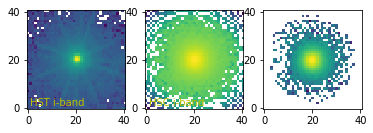

In [20]:
## The pixel scale of the kernel is now downsampled!

from skimage.transform import downscale_local_mean
psf = pyfits.getdata('psf_i.fits')
psf = downscale_local_mean(psf,(3,3))
psf = psf[7:-8,7:-8]#[22:-22,22:-22]
print(psf.shape)
plt.subplot(1,3,1)
plt.imshow(np.log(psf),origin='lower')
plt.text(1,1,'HST i-band',color='y')

from scipy.ndimage import zoom
psf_hsc = pyfits.getdata('psf-calexp-s16a_wide-HSC-I-15827-7,2-236.00000-42.00000.fits')
psf_hsc = psf_hsc[0:41,1:42]
#psf_hsc = zoom(psf_hsc, 3, order=1)
print(psf_hsc.shape)
plt.subplot(1,3,2)
plt.imshow(np.log(psf_hsc),origin='lower')
plt.text(1,1,'HSC i-band',color='y')

kern = create_matching_kernel(psf,psf_hsc)
plt.subplot(1,3,3)
print(kern.shape)
#kern = kern[35:-35,35:-35]
plt.imshow(np.log(kern),origin='lower')

psfh = np.repeat(kern[:,:, np.newaxis], 1, axis=2)
psfh = np.repeat(psfh[:,:,:,np.newaxis],1,axis = 3)
kernel = torch.Tensor(psfh)
kernel = kernel.permute(2,3,0,1)
kernel =  kernel.float()

In [21]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


In [22]:
class Shoobygen(nn.Module):

    def __init__(self,ngpu):
        super(Shoobygen, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(

            nn.ConvTranspose2d( 1, ngf * 8, 4, 1, 2, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 2, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
  
            nn.ConvTranspose2d(ngf*4, nc, 2, 2, 4, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
            output1 = output[:,:,2:-2,2:-2]

        else:
            output = self.main(input)
            output1 = output[:,:,2:-2,2:-2]

        return output1

netS = Shoobygen(ngpu).to(device)
netS.apply(weights_init)
print(netS)

Shoobygen(
  (main): Sequential(
    (0): ConvTranspose2d(1, 512, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 1, kernel_size=(2, 2), stride=(2, 2), padding=(4, 4), bias=False)
    (7): Tanh()
  )
)


In [23]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)


netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
#if netD != '':
#    netD.load_state_dict(torch.load(netD))
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [24]:
criterion = nn.BCELoss()

real_label = 1
fake_label = 0

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerS = optim.Adam(netS.parameters(), lr=lr, betas=(beta1, 0.999))

for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with resampled, lower res, noise added images
        kernel = kernel.to(device)
        im = real_cpu+0.25*torch.rand_like(real_cpu)
        downsampled = F.upsample(im,scale_factor=1/3,mode='bilinear')
        img = F.conv2d(downsampled, kernel,padding=int(((kernel.shape[3])-1)/2))
        img = img[:,:,:,:]

        fake = netS(img)
        label.fill_(fake_label)
        fd = fake.detach()
        output = netD(fd.float())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netS.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerS.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, niter, i, len(dataloader),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        if i % 100 == 0:
            vutils.save_image(real_cpu,
                    '%s/real_samples.png' % outf,
                    normalize=True)
            fake = netS(img)
            vutils.save_image(fake.detach(),
                    '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
                    normalize=True)
    # do checkpointing
    torch.save(netS.state_dict(), '%s/netG_epoch_%d.pth' % (outf, epoch))
    torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (outf, epoch))

[0/100][0/95] Loss_D: 2.2082 Loss_G: 7.5426 D(x): 0.2595 D(G(z)): 0.5065 / 0.0287
[0/100][1/95] Loss_D: 1.2705 Loss_G: 9.3080 D(x): 0.9998 D(G(z)): 0.6776 / 0.0161
[0/100][2/95] Loss_D: 0.1534 Loss_G: 8.7917 D(x): 1.0000 D(G(z)): 0.1256 / 0.0058
[0/100][3/95] Loss_D: 0.2949 Loss_G: 7.9141 D(x): 0.9933 D(G(z)): 0.2120 / 0.0044
[0/100][4/95] Loss_D: 0.1080 Loss_G: 7.6275 D(x): 0.9999 D(G(z)): 0.0948 / 0.0053
[0/100][5/95] Loss_D: 0.3253 Loss_G: 10.9741 D(x): 0.9999 D(G(z)): 0.2496 / 0.0007
[0/100][6/95] Loss_D: 0.0412 Loss_G: 10.2868 D(x): 0.9875 D(G(z)): 0.0184 / 0.0030
[0/100][7/95] Loss_D: 0.3480 Loss_G: 6.9382 D(x): 0.9265 D(G(z)): 0.0520 / 0.0039
[0/100][8/95] Loss_D: 0.0753 Loss_G: 7.2051 D(x): 0.9990 D(G(z)): 0.0680 / 0.0022
[0/100][9/95] Loss_D: 0.0371 Loss_G: 7.1259 D(x): 0.9950 D(G(z)): 0.0303 / 0.0023
[0/100][10/95] Loss_D: 0.0546 Loss_G: 6.3104 D(x): 0.9844 D(G(z)): 0.0225 / 0.0057
[0/100][11/95] Loss_D: 0.0164 Loss_G: 6.4209 D(x): 0.9999 D(G(z)): 0.0161 / 0.0020
[0/100][12/9

[1/100][6/95] Loss_D: 0.6712 Loss_G: 3.7943 D(x): 0.8437 D(G(z)): 0.2472 / 0.0645
[1/100][7/95] Loss_D: 0.2644 Loss_G: 3.6216 D(x): 0.8396 D(G(z)): 0.0561 / 0.0561
[1/100][8/95] Loss_D: 0.1272 Loss_G: 6.0598 D(x): 0.9018 D(G(z)): 0.0099 / 0.0146
[1/100][9/95] Loss_D: 0.9191 Loss_G: 5.3049 D(x): 0.9252 D(G(z)): 0.4561 / 0.0147
[1/100][10/95] Loss_D: 1.4106 Loss_G: 4.4712 D(x): 0.3985 D(G(z)): 0.0035 / 0.0387
[1/100][11/95] Loss_D: 0.7854 Loss_G: 3.7395 D(x): 0.8919 D(G(z)): 0.3851 / 0.0554
[1/100][12/95] Loss_D: 0.1877 Loss_G: 4.1917 D(x): 0.8949 D(G(z)): 0.0433 / 0.0375
[1/100][13/95] Loss_D: 0.5395 Loss_G: 6.5607 D(x): 0.9570 D(G(z)): 0.3385 / 0.0044
[1/100][14/95] Loss_D: 0.9131 Loss_G: 4.0332 D(x): 0.4863 D(G(z)): 0.0064 / 0.0553
[1/100][15/95] Loss_D: 0.5109 Loss_G: 3.7856 D(x): 0.9751 D(G(z)): 0.3307 / 0.0552
[1/100][16/95] Loss_D: 0.4280 Loss_G: 3.6242 D(x): 0.8030 D(G(z)): 0.0746 / 0.0699
[1/100][17/95] Loss_D: 0.2750 Loss_G: 3.8876 D(x): 0.9747 D(G(z)): 0.1936 / 0.0461
[1/100][

[2/100][10/95] Loss_D: 0.1110 Loss_G: 10.8512 D(x): 0.9280 D(G(z)): 0.0056 / 0.0011
[2/100][11/95] Loss_D: 0.0110 Loss_G: 11.2645 D(x): 0.9900 D(G(z)): 0.0001 / 0.0002
[2/100][12/95] Loss_D: 0.0059 Loss_G: 9.2064 D(x): 0.9953 D(G(z)): 0.0011 / 0.0012
[2/100][13/95] Loss_D: 0.0159 Loss_G: 5.4613 D(x): 0.9994 D(G(z)): 0.0151 / 0.0124
[2/100][14/95] Loss_D: 0.0157 Loss_G: 5.3944 D(x): 0.9962 D(G(z)): 0.0116 / 0.0093
[2/100][15/95] Loss_D: 0.0680 Loss_G: 6.9081 D(x): 0.9529 D(G(z)): 0.0109 / 0.0034
[2/100][16/95] Loss_D: 0.0074 Loss_G: 6.4091 D(x): 0.9988 D(G(z)): 0.0061 / 0.0068
[2/100][17/95] Loss_D: 0.1369 Loss_G: 5.7120 D(x): 0.9993 D(G(z)): 0.0847 / 0.0151
[2/100][18/95] Loss_D: 0.0044 Loss_G: 10.6602 D(x): 0.9962 D(G(z)): 0.0005 / 0.0004
[2/100][19/95] Loss_D: 0.0062 Loss_G: 9.3854 D(x): 0.9944 D(G(z)): 0.0005 / 0.0005
[2/100][20/95] Loss_D: 0.0297 Loss_G: 5.3472 D(x): 0.9881 D(G(z)): 0.0172 / 0.0120
[2/100][21/95] Loss_D: 0.0340 Loss_G: 11.9931 D(x): 0.9803 D(G(z)): 0.0005 / 0.0006


[3/100][14/95] Loss_D: 0.0042 Loss_G: 10.3454 D(x): 0.9961 D(G(z)): 0.0002 / 0.0002
[3/100][15/95] Loss_D: 0.0044 Loss_G: 8.8079 D(x): 0.9963 D(G(z)): 0.0006 / 0.0006
[3/100][16/95] Loss_D: 0.0060 Loss_G: 7.0361 D(x): 0.9980 D(G(z)): 0.0039 / 0.0038
[3/100][17/95] Loss_D: 0.0024 Loss_G: 11.5987 D(x): 0.9977 D(G(z)): 0.0001 / 0.0001
[3/100][18/95] Loss_D: 0.0007 Loss_G: 10.9933 D(x): 0.9996 D(G(z)): 0.0003 / 0.0003
[3/100][19/95] Loss_D: 0.0027 Loss_G: 8.9984 D(x): 0.9980 D(G(z)): 0.0007 / 0.0007
[3/100][20/95] Loss_D: 0.0044 Loss_G: 7.5953 D(x): 0.9970 D(G(z)): 0.0012 / 0.0013
[3/100][21/95] Loss_D: 0.0248 Loss_G: 5.6691 D(x): 0.9973 D(G(z)): 0.0215 / 0.0139
[3/100][22/95] Loss_D: 0.0177 Loss_G: 6.5522 D(x): 0.9994 D(G(z)): 0.0158 / 0.0073
[3/100][23/95] Loss_D: 0.0083 Loss_G: 12.0522 D(x): 0.9923 D(G(z)): 0.0001 / 0.0001
[3/100][24/95] Loss_D: 0.0120 Loss_G: 12.0980 D(x): 0.9905 D(G(z)): 0.0001 / 0.0001
[3/100][25/95] Loss_D: 0.0020 Loss_G: 11.4426 D(x): 0.9982 D(G(z)): 0.0002 / 0.000

[4/100][18/95] Loss_D: 0.0013 Loss_G: 10.1903 D(x): 0.9989 D(G(z)): 0.0001 / 0.0001
[4/100][19/95] Loss_D: 0.0005 Loss_G: 9.2844 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[4/100][20/95] Loss_D: 0.0021 Loss_G: 7.7571 D(x): 0.9990 D(G(z)): 0.0011 / 0.0011
[4/100][21/95] Loss_D: 0.0041 Loss_G: 6.8105 D(x): 0.9986 D(G(z)): 0.0026 / 0.0024
[4/100][22/95] Loss_D: 0.0007 Loss_G: 9.9470 D(x): 0.9996 D(G(z)): 0.0003 / 0.0003
[4/100][23/95] Loss_D: 0.0011 Loss_G: 8.4731 D(x): 0.9994 D(G(z)): 0.0005 / 0.0005
[4/100][24/95] Loss_D: 0.0017 Loss_G: 9.0947 D(x): 0.9988 D(G(z)): 0.0005 / 0.0005
[4/100][25/95] Loss_D: 0.0334 Loss_G: 5.2885 D(x): 0.9980 D(G(z)): 0.0304 / 0.0121
[4/100][26/95] Loss_D: 0.0077 Loss_G: 8.8724 D(x): 0.9933 D(G(z)): 0.0006 / 0.0005
[4/100][27/95] Loss_D: 0.0039 Loss_G: 7.9500 D(x): 0.9992 D(G(z)): 0.0031 / 0.0026
[4/100][28/95] Loss_D: 0.0091 Loss_G: 6.4614 D(x): 0.9962 D(G(z)): 0.0051 / 0.0037
[4/100][29/95] Loss_D: 0.0033 Loss_G: 13.6552 D(x): 0.9969 D(G(z)): 0.0000 / 0.0000
[4

[5/100][22/95] Loss_D: 0.0012 Loss_G: 8.3744 D(x): 0.9998 D(G(z)): 0.0011 / 0.0010
[5/100][23/95] Loss_D: 0.0011 Loss_G: 8.3716 D(x): 0.9998 D(G(z)): 0.0009 / 0.0008
[5/100][24/95] Loss_D: 0.0006 Loss_G: 9.3232 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[5/100][25/95] Loss_D: 0.0007 Loss_G: 8.4079 D(x): 1.0000 D(G(z)): 0.0007 / 0.0007
[5/100][26/95] Loss_D: 0.0007 Loss_G: 8.7382 D(x): 0.9999 D(G(z)): 0.0006 / 0.0006
[5/100][27/95] Loss_D: 0.0007 Loss_G: 8.8393 D(x): 1.0000 D(G(z)): 0.0007 / 0.0007
[5/100][28/95] Loss_D: 0.0008 Loss_G: 8.5500 D(x): 1.0000 D(G(z)): 0.0008 / 0.0008
[5/100][29/95] Loss_D: 0.0006 Loss_G: 8.7332 D(x): 0.9999 D(G(z)): 0.0006 / 0.0005
[5/100][30/95] Loss_D: 0.0006 Loss_G: 8.7797 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[5/100][31/95] Loss_D: 0.0011 Loss_G: 8.6642 D(x): 0.9998 D(G(z)): 0.0009 / 0.0009
[5/100][32/95] Loss_D: 0.0007 Loss_G: 8.3120 D(x): 1.0000 D(G(z)): 0.0007 / 0.0006
[5/100][33/95] Loss_D: 0.0013 Loss_G: 8.0746 D(x): 0.9999 D(G(z)): 0.0012 / 0.0011
[5/1

[6/100][26/95] Loss_D: 0.0010 Loss_G: 7.9190 D(x): 0.9999 D(G(z)): 0.0010 / 0.0009
[6/100][27/95] Loss_D: 0.0005 Loss_G: 9.2027 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[6/100][28/95] Loss_D: 0.0017 Loss_G: 8.0902 D(x): 0.9992 D(G(z)): 0.0010 / 0.0009
[6/100][29/95] Loss_D: 0.0009 Loss_G: 8.5657 D(x): 0.9997 D(G(z)): 0.0006 / 0.0005
[6/100][30/95] Loss_D: 0.0019 Loss_G: 7.6776 D(x): 0.9999 D(G(z)): 0.0018 / 0.0015
[6/100][31/95] Loss_D: 0.0005 Loss_G: 8.9579 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[6/100][32/95] Loss_D: 0.0006 Loss_G: 10.3024 D(x): 0.9996 D(G(z)): 0.0002 / 0.0001
[6/100][33/95] Loss_D: 0.0009 Loss_G: 8.2639 D(x): 0.9999 D(G(z)): 0.0008 / 0.0008
[6/100][34/95] Loss_D: 0.0007 Loss_G: 8.0957 D(x): 0.9999 D(G(z)): 0.0007 / 0.0006
[6/100][35/95] Loss_D: 0.0003 Loss_G: 11.0741 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[6/100][36/95] Loss_D: 0.0014 Loss_G: 9.0555 D(x): 0.9992 D(G(z)): 0.0006 / 0.0006
[6/100][37/95] Loss_D: 0.0009 Loss_G: 8.2988 D(x): 0.9997 D(G(z)): 0.0006 / 0.0006
[6

[7/100][30/95] Loss_D: 0.0008 Loss_G: 14.5132 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[7/100][31/95] Loss_D: 0.1391 Loss_G: 12.9054 D(x): 0.9466 D(G(z)): 0.0000 / 0.0000
[7/100][32/95] Loss_D: 0.0058 Loss_G: 12.1377 D(x): 0.9951 D(G(z)): 0.0000 / 0.0000
[7/100][33/95] Loss_D: 0.0001 Loss_G: 12.8348 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[7/100][34/95] Loss_D: 0.0002 Loss_G: 11.6790 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[7/100][35/95] Loss_D: 0.0002 Loss_G: 11.9692 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[7/100][36/95] Loss_D: 0.0003 Loss_G: 11.4149 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[7/100][37/95] Loss_D: 0.0017 Loss_G: 11.2180 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[7/100][38/95] Loss_D: 0.0002 Loss_G: 10.4964 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[7/100][39/95] Loss_D: 0.0002 Loss_G: 10.8235 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[7/100][40/95] Loss_D: 0.0002 Loss_G: 10.8237 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[7/100][41/95] Loss_D: 0.0002 Loss_G: 9.8634 D(x): 0.9999 D(G(z)): 0.0001 / 

[8/100][34/95] Loss_D: 0.0004 Loss_G: 9.6197 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[8/100][35/95] Loss_D: 0.0003 Loss_G: 10.1768 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[8/100][36/95] Loss_D: 0.0004 Loss_G: 9.5864 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[8/100][37/95] Loss_D: 0.0005 Loss_G: 9.0971 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[8/100][38/95] Loss_D: 0.0003 Loss_G: 10.0273 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[8/100][39/95] Loss_D: 0.0006 Loss_G: 9.3629 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[8/100][40/95] Loss_D: 0.0003 Loss_G: 10.0669 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[8/100][41/95] Loss_D: 0.0005 Loss_G: 9.3885 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[8/100][42/95] Loss_D: 0.0004 Loss_G: 9.5758 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[8/100][43/95] Loss_D: 0.0005 Loss_G: 9.2031 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[8/100][44/95] Loss_D: 0.0007 Loss_G: 8.9014 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[8/100][45/95] Loss_D: 0.0006 Loss_G: 9.4834 D(x): 0.9999 D(G(z)): 0.0006 / 0.0006
[

[9/100][38/95] Loss_D: 0.0007 Loss_G: 8.4723 D(x): 1.0000 D(G(z)): 0.0007 / 0.0006
[9/100][39/95] Loss_D: 0.0005 Loss_G: 9.1388 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[9/100][40/95] Loss_D: 0.0106 Loss_G: 8.7152 D(x): 0.9905 D(G(z)): 0.0005 / 0.0005
[9/100][41/95] Loss_D: 0.0009 Loss_G: 8.2723 D(x): 0.9998 D(G(z)): 0.0007 / 0.0006
[9/100][42/95] Loss_D: 0.0012 Loss_G: 8.0657 D(x): 0.9999 D(G(z)): 0.0011 / 0.0011
[9/100][43/95] Loss_D: 0.0005 Loss_G: 8.8132 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[9/100][44/95] Loss_D: 0.0002 Loss_G: 10.6233 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[9/100][45/95] Loss_D: 0.0001 Loss_G: 10.5781 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[9/100][46/95] Loss_D: 0.0000 Loss_G: 11.6781 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[9/100][47/95] Loss_D: 0.0005 Loss_G: 8.6304 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[9/100][48/95] Loss_D: 0.0003 Loss_G: 9.5481 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[9/100][49/95] Loss_D: 0.0010 Loss_G: 8.8845 D(x): 0.9997 D(G(z)): 0.0006 / 0.0006
[

[10/100][42/95] Loss_D: 0.0002 Loss_G: 9.5943 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[10/100][43/95] Loss_D: 0.0002 Loss_G: 10.6097 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[10/100][44/95] Loss_D: 0.0003 Loss_G: 9.2633 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[10/100][45/95] Loss_D: 0.0005 Loss_G: 8.8601 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[10/100][46/95] Loss_D: 0.0005 Loss_G: 9.4865 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[10/100][47/95] Loss_D: 0.0003 Loss_G: 9.4275 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[10/100][48/95] Loss_D: 0.0003 Loss_G: 9.7748 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[10/100][49/95] Loss_D: 0.0006 Loss_G: 8.5749 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[10/100][50/95] Loss_D: 0.0006 Loss_G: 8.7967 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[10/100][51/95] Loss_D: 0.0004 Loss_G: 9.4581 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[10/100][52/95] Loss_D: 0.0009 Loss_G: 9.3195 D(x): 0.9995 D(G(z)): 0.0003 / 0.0003
[10/100][53/95] Loss_D: 0.0003 Loss_G: 10.0686 D(x): 1.0000 D(G(z)): 0.0002

[11/100][46/95] Loss_D: 0.0005 Loss_G: 9.1915 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[11/100][47/95] Loss_D: 0.0001 Loss_G: 12.4078 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[11/100][48/95] Loss_D: 0.0001 Loss_G: 11.1083 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[11/100][49/95] Loss_D: 0.0002 Loss_G: 10.2049 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[11/100][50/95] Loss_D: 0.0003 Loss_G: 10.8883 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[11/100][51/95] Loss_D: 0.0005 Loss_G: 9.5295 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[11/100][52/95] Loss_D: 0.0001 Loss_G: 11.1798 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[11/100][53/95] Loss_D: 0.0003 Loss_G: 9.6681 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[11/100][54/95] Loss_D: 0.0005 Loss_G: 9.0104 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[11/100][55/95] Loss_D: 0.0011 Loss_G: 8.5216 D(x): 1.0000 D(G(z)): 0.0011 / 0.0010
[11/100][56/95] Loss_D: 0.0006 Loss_G: 8.8911 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[11/100][57/95] Loss_D: 0.0008 Loss_G: 8.7241 D(x): 1.0000 D(G(z)): 0.0

[12/100][50/95] Loss_D: 0.0006 Loss_G: 9.0321 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[12/100][51/95] Loss_D: 0.0004 Loss_G: 10.4366 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[12/100][52/95] Loss_D: 0.0003 Loss_G: 10.1759 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[12/100][53/95] Loss_D: 0.0004 Loss_G: 9.2393 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[12/100][54/95] Loss_D: 0.0006 Loss_G: 8.8203 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[12/100][55/95] Loss_D: 0.0005 Loss_G: 8.6789 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[12/100][56/95] Loss_D: 0.0005 Loss_G: 8.7613 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[12/100][57/95] Loss_D: 0.0004 Loss_G: 10.2917 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[12/100][58/95] Loss_D: 0.0001 Loss_G: 10.7582 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[12/100][59/95] Loss_D: 0.0002 Loss_G: 10.2248 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[12/100][60/95] Loss_D: 0.0005 Loss_G: 9.0265 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[12/100][61/95] Loss_D: 0.0007 Loss_G: 9.0007 D(x): 0.9999 D(G(z)): 0.0

[13/100][53/95] Loss_D: 0.0004 Loss_G: 8.6760 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[13/100][54/95] Loss_D: 0.0006 Loss_G: 8.6550 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[13/100][55/95] Loss_D: 0.0049 Loss_G: 8.0592 D(x): 0.9962 D(G(z)): 0.0010 / 0.0009
[13/100][56/95] Loss_D: 0.0006 Loss_G: 8.7158 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[13/100][57/95] Loss_D: 0.0003 Loss_G: 9.4884 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[13/100][58/95] Loss_D: 0.0000 Loss_G: 11.3659 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[13/100][59/95] Loss_D: 0.0008 Loss_G: 10.1003 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[13/100][60/95] Loss_D: 0.0002 Loss_G: 9.6486 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[13/100][61/95] Loss_D: 0.0004 Loss_G: 8.6728 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[13/100][62/95] Loss_D: 0.0003 Loss_G: 8.7859 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[13/100][63/95] Loss_D: 0.0002 Loss_G: 9.5955 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[13/100][64/95] Loss_D: 0.0006 Loss_G: 8.6963 D(x): 0.9999 D(G(z)): 0.0004

[14/100][57/95] Loss_D: 0.0238 Loss_G: 6.7276 D(x): 1.0000 D(G(z)): 0.0232 / 0.0025
[14/100][58/95] Loss_D: 0.0011 Loss_G: 8.9173 D(x): 0.9999 D(G(z)): 0.0010 / 0.0006
[14/100][59/95] Loss_D: 0.0002 Loss_G: 11.3527 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[14/100][60/95] Loss_D: 0.0004 Loss_G: 8.9431 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[14/100][61/95] Loss_D: 0.0074 Loss_G: 11.5887 D(x): 0.9931 D(G(z)): 0.0001 / 0.0001
[14/100][62/95] Loss_D: 0.0002 Loss_G: 10.9861 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[14/100][63/95] Loss_D: 0.0012 Loss_G: 7.4940 D(x): 1.0000 D(G(z)): 0.0011 / 0.0011
[14/100][64/95] Loss_D: 0.0405 Loss_G: 7.6449 D(x): 0.9999 D(G(z)): 0.0382 / 0.0013
[14/100][65/95] Loss_D: 0.0001 Loss_G: 12.9758 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[14/100][66/95] Loss_D: 0.0024 Loss_G: 11.3213 D(x): 0.9990 D(G(z)): 0.0014 / 0.0003
[14/100][67/95] Loss_D: 0.0029 Loss_G: 11.3630 D(x): 0.9973 D(G(z)): 0.0000 / 0.0000
[14/100][68/95] Loss_D: 0.0018 Loss_G: 11.2128 D(x): 0.9983 D(G(z)): 0

[15/100][59/95] Loss_D: 0.0023 Loss_G: 8.6325 D(x): 0.9981 D(G(z)): 0.0003 / 0.0004
[15/100][60/95] Loss_D: 0.0020 Loss_G: 8.6248 D(x): 0.9983 D(G(z)): 0.0003 / 0.0003
[15/100][61/95] Loss_D: 0.0008 Loss_G: 10.1634 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[15/100][62/95] Loss_D: 0.0005 Loss_G: 9.0242 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[15/100][63/95] Loss_D: 0.0023 Loss_G: 8.0118 D(x): 0.9990 D(G(z)): 0.0013 / 0.0012
[15/100][64/95] Loss_D: 0.0000 Loss_G: 14.8008 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[15/100][65/95] Loss_D: 0.0001 Loss_G: 13.5776 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[15/100][66/95] Loss_D: 0.0007 Loss_G: 11.9728 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[15/100][67/95] Loss_D: 0.0004 Loss_G: 11.4686 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[15/100][68/95] Loss_D: 0.0001 Loss_G: 11.0662 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[15/100][69/95] Loss_D: 0.0003 Loss_G: 10.4509 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[15/100][70/95] Loss_D: 0.0067 Loss_G: 9.7500 D(x): 0.9941 D(G(z)): 0

[16/100][62/95] Loss_D: 0.0003 Loss_G: 14.1772 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[16/100][63/95] Loss_D: 0.0006 Loss_G: 12.6686 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[16/100][64/95] Loss_D: 0.0000 Loss_G: 12.0587 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[16/100][65/95] Loss_D: 0.0002 Loss_G: 10.4250 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[16/100][66/95] Loss_D: 0.0005 Loss_G: 9.8638 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[16/100][67/95] Loss_D: 0.0000 Loss_G: 14.9691 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[16/100][68/95] Loss_D: 0.0002 Loss_G: 9.7760 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[16/100][69/95] Loss_D: 0.0001 Loss_G: 10.7641 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[16/100][70/95] Loss_D: 0.0006 Loss_G: 9.4240 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[16/100][71/95] Loss_D: 0.0002 Loss_G: 9.1687 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[16/100][72/95] Loss_D: 0.0012 Loss_G: 8.6974 D(x): 0.9995 D(G(z)): 0.0007 / 0.0006
[16/100][73/95] Loss_D: 0.0002 Loss_G: 9.3295 D(x): 0.9999 D(G(z)): 0.

[17/100][66/95] Loss_D: 0.0001 Loss_G: 10.8054 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[17/100][67/95] Loss_D: 0.0222 Loss_G: 8.6968 D(x): 1.0000 D(G(z)): 0.0218 / 0.0004
[17/100][68/95] Loss_D: 0.0006 Loss_G: 12.8905 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[17/100][69/95] Loss_D: 0.0021 Loss_G: 11.8048 D(x): 0.9980 D(G(z)): 0.0000 / 0.0000
[17/100][70/95] Loss_D: 0.0014 Loss_G: 10.4194 D(x): 0.9987 D(G(z)): 0.0001 / 0.0001
[17/100][71/95] Loss_D: 0.0004 Loss_G: 15.0571 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[17/100][72/95] Loss_D: 0.0011 Loss_G: 12.6520 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[17/100][73/95] Loss_D: 0.0030 Loss_G: 15.2302 D(x): 0.9972 D(G(z)): 0.0000 / 0.0000
[17/100][74/95] Loss_D: 0.0002 Loss_G: 13.2611 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[17/100][75/95] Loss_D: 0.0010 Loss_G: 12.2211 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[17/100][76/95] Loss_D: 0.0020 Loss_G: 8.1289 D(x): 0.9986 D(G(z)): 0.0005 / 0.0006
[17/100][77/95] Loss_D: 0.0001 Loss_G: 14.9423 D(x): 0.9999 D(G(z))

[18/100][70/95] Loss_D: 2.4787 Loss_G: 0.6898 D(x): 0.1598 D(G(z)): 0.0039 / 0.6009
[18/100][71/95] Loss_D: 1.7989 Loss_G: 4.9928 D(x): 0.9584 D(G(z)): 0.7615 / 0.0423
[18/100][72/95] Loss_D: 0.9316 Loss_G: 2.7204 D(x): 0.5427 D(G(z)): 0.0874 / 0.1036
[18/100][73/95] Loss_D: 0.9874 Loss_G: 0.3154 D(x): 0.4780 D(G(z)): 0.0412 / 0.7761
[18/100][74/95] Loss_D: 2.3965 Loss_G: 4.5046 D(x): 0.9791 D(G(z)): 0.8345 / 0.0220
[18/100][75/95] Loss_D: 0.7963 Loss_G: 3.1735 D(x): 0.5280 D(G(z)): 0.0342 / 0.0796
[18/100][76/95] Loss_D: 0.3611 Loss_G: 2.2891 D(x): 0.8834 D(G(z)): 0.1808 / 0.1288
[18/100][77/95] Loss_D: 0.4016 Loss_G: 2.3539 D(x): 0.8329 D(G(z)): 0.1620 / 0.1241
[18/100][78/95] Loss_D: 0.5002 Loss_G: 2.7207 D(x): 0.8286 D(G(z)): 0.2250 / 0.1145
[18/100][79/95] Loss_D: 0.3282 Loss_G: 2.5536 D(x): 0.7955 D(G(z)): 0.0716 / 0.1114
[18/100][80/95] Loss_D: 0.5062 Loss_G: 2.9501 D(x): 0.8681 D(G(z)): 0.2685 / 0.0926
[18/100][81/95] Loss_D: 0.7393 Loss_G: 1.4743 D(x): 0.6695 D(G(z)): 0.1126 /

[19/100][74/95] Loss_D: 0.0235 Loss_G: 4.9543 D(x): 0.9916 D(G(z)): 0.0147 / 0.0139
[19/100][75/95] Loss_D: 0.0127 Loss_G: 6.1830 D(x): 0.9942 D(G(z)): 0.0067 / 0.0067
[19/100][76/95] Loss_D: 0.0623 Loss_G: 5.7091 D(x): 0.9912 D(G(z)): 0.0255 / 0.0220
[19/100][77/95] Loss_D: 0.0167 Loss_G: 7.0467 D(x): 0.9907 D(G(z)): 0.0061 / 0.0059
[19/100][78/95] Loss_D: 0.0214 Loss_G: 5.6768 D(x): 0.9967 D(G(z)): 0.0178 / 0.0158
[19/100][79/95] Loss_D: 0.0273 Loss_G: 5.3480 D(x): 0.9959 D(G(z)): 0.0228 / 0.0195
[19/100][80/95] Loss_D: 0.0217 Loss_G: 5.7322 D(x): 0.9954 D(G(z)): 0.0167 / 0.0143
[19/100][81/95] Loss_D: 0.0251 Loss_G: 5.2964 D(x): 0.9912 D(G(z)): 0.0156 / 0.0137
[19/100][82/95] Loss_D: 0.0517 Loss_G: 4.7902 D(x): 0.9916 D(G(z)): 0.0343 / 0.0279
[19/100][83/95] Loss_D: 0.0326 Loss_G: 4.8259 D(x): 0.9906 D(G(z)): 0.0223 / 0.0176
[19/100][84/95] Loss_D: 0.0258 Loss_G: 4.7716 D(x): 0.9932 D(G(z)): 0.0186 / 0.0160
[19/100][85/95] Loss_D: 0.0285 Loss_G: 5.0403 D(x): 0.9940 D(G(z)): 0.0211 /

[20/100][77/95] Loss_D: 0.0046 Loss_G: 8.3751 D(x): 0.9961 D(G(z)): 0.0006 / 0.0006
[20/100][78/95] Loss_D: 0.0088 Loss_G: 5.6057 D(x): 0.9986 D(G(z)): 0.0073 / 0.0067
[20/100][79/95] Loss_D: 0.0160 Loss_G: 6.1285 D(x): 0.9899 D(G(z)): 0.0044 / 0.0044
[20/100][80/95] Loss_D: 0.0088 Loss_G: 5.4336 D(x): 0.9992 D(G(z)): 0.0080 / 0.0070
[20/100][81/95] Loss_D: 0.0036 Loss_G: 6.4243 D(x): 0.9993 D(G(z)): 0.0029 / 0.0026
[20/100][82/95] Loss_D: 0.0016 Loss_G: 7.6247 D(x): 0.9994 D(G(z)): 0.0010 / 0.0010
[20/100][83/95] Loss_D: 0.0057 Loss_G: 5.9092 D(x): 0.9983 D(G(z)): 0.0040 / 0.0037
[20/100][84/95] Loss_D: 0.0037 Loss_G: 6.5544 D(x): 0.9988 D(G(z)): 0.0024 / 0.0023
[20/100][85/95] Loss_D: 0.0054 Loss_G: 6.2604 D(x): 0.9986 D(G(z)): 0.0039 / 0.0035
[20/100][86/95] Loss_D: 0.0037 Loss_G: 6.7215 D(x): 0.9986 D(G(z)): 0.0022 / 0.0021
[20/100][87/95] Loss_D: 0.0078 Loss_G: 5.6646 D(x): 0.9989 D(G(z)): 0.0066 / 0.0061
[20/100][88/95] Loss_D: 0.0055 Loss_G: 6.1045 D(x): 0.9993 D(G(z)): 0.0048 /

[21/100][82/95] Loss_D: 0.0024 Loss_G: 6.6919 D(x): 0.9999 D(G(z)): 0.0023 / 0.0022
[21/100][83/95] Loss_D: 0.0036 Loss_G: 6.5869 D(x): 0.9995 D(G(z)): 0.0030 / 0.0029
[21/100][84/95] Loss_D: 0.0063 Loss_G: 5.9849 D(x): 0.9998 D(G(z)): 0.0061 / 0.0054
[21/100][85/95] Loss_D: 0.0029 Loss_G: 6.4866 D(x): 0.9999 D(G(z)): 0.0028 / 0.0025
[21/100][86/95] Loss_D: 0.0075 Loss_G: 5.6763 D(x): 0.9997 D(G(z)): 0.0071 / 0.0057
[21/100][87/95] Loss_D: 0.0005 Loss_G: 8.9914 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[21/100][88/95] Loss_D: 0.0006 Loss_G: 8.3521 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[21/100][89/95] Loss_D: 0.0123 Loss_G: 5.1123 D(x): 0.9999 D(G(z)): 0.0121 / 0.0092
[21/100][90/95] Loss_D: 0.0022 Loss_G: 7.1582 D(x): 0.9998 D(G(z)): 0.0020 / 0.0017
[21/100][91/95] Loss_D: 0.0014 Loss_G: 7.1956 D(x): 1.0000 D(G(z)): 0.0014 / 0.0012
[21/100][92/95] Loss_D: 0.0017 Loss_G: 7.3445 D(x): 0.9994 D(G(z)): 0.0012 / 0.0011
[21/100][93/95] Loss_D: 0.0293 Loss_G: 4.7636 D(x): 0.9997 D(G(z)): 0.0283 /

[22/100][87/95] Loss_D: 0.0009 Loss_G: 12.7579 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[22/100][88/95] Loss_D: 0.0007 Loss_G: 11.5728 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[22/100][89/95] Loss_D: 0.0021 Loss_G: 7.4782 D(x): 0.9991 D(G(z)): 0.0012 / 0.0012
[22/100][90/95] Loss_D: 0.0009 Loss_G: 10.9873 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[22/100][91/95] Loss_D: 0.0006 Loss_G: 10.8285 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[22/100][92/95] Loss_D: 0.0011 Loss_G: 8.2693 D(x): 0.9995 D(G(z)): 0.0006 / 0.0006
[22/100][93/95] Loss_D: 0.0020 Loss_G: 7.0387 D(x): 0.9997 D(G(z)): 0.0017 / 0.0015
[22/100][94/95] Loss_D: 0.0061 Loss_G: 6.1406 D(x): 0.9980 D(G(z)): 0.0040 / 0.0031
[23/100][0/95] Loss_D: 0.0009 Loss_G: 12.1525 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[23/100][1/95] Loss_D: 0.0003 Loss_G: 11.6978 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[23/100][2/95] Loss_D: 0.0026 Loss_G: 7.0131 D(x): 0.9997 D(G(z)): 0.0023 / 0.0021
[23/100][3/95] Loss_D: 0.0020 Loss_G: 7.9057 D(x): 0.9996 D(G(z)): 0.0017

[23/100][93/95] Loss_D: 0.8109 Loss_G: 5.5714 D(x): 0.9973 D(G(z)): 0.4451 / 0.0107
[23/100][94/95] Loss_D: 0.4925 Loss_G: 3.6118 D(x): 0.8220 D(G(z)): 0.0498 / 0.0303
[24/100][0/95] Loss_D: 0.2015 Loss_G: 6.9880 D(x): 0.8843 D(G(z)): 0.0011 / 0.0025
[24/100][1/95] Loss_D: 0.0253 Loss_G: 4.7658 D(x): 0.9866 D(G(z)): 0.0109 / 0.0183
[24/100][2/95] Loss_D: 0.0630 Loss_G: 3.6651 D(x): 0.9892 D(G(z)): 0.0487 / 0.0380
[24/100][3/95] Loss_D: 0.5409 Loss_G: 6.4659 D(x): 0.9810 D(G(z)): 0.3084 / 0.0153
[24/100][4/95] Loss_D: 0.4005 Loss_G: 4.7363 D(x): 0.7875 D(G(z)): 0.0086 / 0.0247
[24/100][5/95] Loss_D: 0.0894 Loss_G: 4.1520 D(x): 0.9884 D(G(z)): 0.0596 / 0.0578
[24/100][6/95] Loss_D: 0.0172 Loss_G: 5.2175 D(x): 0.9992 D(G(z)): 0.0160 / 0.0109
[24/100][7/95] Loss_D: 0.3072 Loss_G: 7.9880 D(x): 0.9993 D(G(z)): 0.2127 / 0.0010
[24/100][8/95] Loss_D: 0.0402 Loss_G: 7.7637 D(x): 0.9704 D(G(z)): 0.0042 / 0.0031
[24/100][9/95] Loss_D: 0.0674 Loss_G: 8.3823 D(x): 0.9405 D(G(z)): 0.0015 / 0.0022
[2

[25/100][2/95] Loss_D: 0.0064 Loss_G: 11.5378 D(x): 0.9940 D(G(z)): 0.0001 / 0.0001
[25/100][3/95] Loss_D: 0.0050 Loss_G: 9.7343 D(x): 0.9955 D(G(z)): 0.0003 / 0.0003
[25/100][4/95] Loss_D: 0.0064 Loss_G: 10.2034 D(x): 0.9942 D(G(z)): 0.0001 / 0.0002
[25/100][5/95] Loss_D: 0.0034 Loss_G: 9.6007 D(x): 0.9970 D(G(z)): 0.0004 / 0.0004
[25/100][6/95] Loss_D: 0.0061 Loss_G: 9.7681 D(x): 0.9944 D(G(z)): 0.0002 / 0.0002
[25/100][7/95] Loss_D: 0.0011 Loss_G: 9.0540 D(x): 0.9992 D(G(z)): 0.0004 / 0.0004
[25/100][8/95] Loss_D: 0.0009 Loss_G: 9.3455 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[25/100][9/95] Loss_D: 0.0105 Loss_G: 7.4388 D(x): 0.9918 D(G(z)): 0.0021 / 0.0021
[25/100][10/95] Loss_D: 0.0016 Loss_G: 8.2239 D(x): 0.9993 D(G(z)): 0.0009 / 0.0009
[25/100][11/95] Loss_D: 0.0012 Loss_G: 7.9206 D(x): 0.9997 D(G(z)): 0.0009 / 0.0009
[25/100][12/95] Loss_D: 0.0035 Loss_G: 7.2714 D(x): 0.9983 D(G(z)): 0.0018 / 0.0017
[25/100][13/95] Loss_D: 0.0021 Loss_G: 7.3132 D(x): 0.9995 D(G(z)): 0.0016 / 0.001

[26/100][5/95] Loss_D: 0.0336 Loss_G: 5.8763 D(x): 0.9994 D(G(z)): 0.0307 / 0.0166
[26/100][6/95] Loss_D: 0.0042 Loss_G: 6.6389 D(x): 0.9994 D(G(z)): 0.0036 / 0.0032
[26/100][7/95] Loss_D: 0.0152 Loss_G: 5.8196 D(x): 0.9979 D(G(z)): 0.0128 / 0.0092
[26/100][8/95] Loss_D: 0.0045 Loss_G: 7.9633 D(x): 0.9972 D(G(z)): 0.0017 / 0.0016
[26/100][9/95] Loss_D: 0.0017 Loss_G: 7.6459 D(x): 0.9996 D(G(z)): 0.0013 / 0.0012
[26/100][10/95] Loss_D: 0.0009 Loss_G: 11.1537 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[26/100][11/95] Loss_D: 0.0041 Loss_G: 6.5244 D(x): 0.9998 D(G(z)): 0.0039 / 0.0038
[26/100][12/95] Loss_D: 0.0054 Loss_G: 6.2889 D(x): 0.9983 D(G(z)): 0.0037 / 0.0036
[26/100][13/95] Loss_D: 0.0047 Loss_G: 6.4987 D(x): 0.9992 D(G(z)): 0.0039 / 0.0038
[26/100][14/95] Loss_D: 0.0091 Loss_G: 5.9843 D(x): 0.9978 D(G(z)): 0.0069 / 0.0065
[26/100][15/95] Loss_D: 0.0034 Loss_G: 7.0739 D(x): 0.9995 D(G(z)): 0.0029 / 0.0028
[26/100][16/95] Loss_D: 0.0177 Loss_G: 5.0122 D(x): 0.9995 D(G(z)): 0.0170 / 0.0

[27/100][9/95] Loss_D: 0.0031 Loss_G: 6.6463 D(x): 0.9999 D(G(z)): 0.0029 / 0.0029
[27/100][10/95] Loss_D: 0.0020 Loss_G: 7.1670 D(x): 1.0000 D(G(z)): 0.0020 / 0.0020
[27/100][11/95] Loss_D: 0.1148 Loss_G: 6.4341 D(x): 0.9999 D(G(z)): 0.0936 / 0.0042
[27/100][12/95] Loss_D: 0.0018 Loss_G: 13.7710 D(x): 0.9982 D(G(z)): 0.0000 / 0.0000
[27/100][13/95] Loss_D: 0.0025 Loss_G: 13.2952 D(x): 0.9975 D(G(z)): 0.0000 / 0.0000
[27/100][14/95] Loss_D: 0.0036 Loss_G: 11.1616 D(x): 0.9965 D(G(z)): 0.0001 / 0.0001
[27/100][15/95] Loss_D: 0.0071 Loss_G: 9.3523 D(x): 0.9936 D(G(z)): 0.0006 / 0.0006
[27/100][16/95] Loss_D: 0.0037 Loss_G: 8.8539 D(x): 0.9968 D(G(z)): 0.0004 / 0.0004
[27/100][17/95] Loss_D: 0.0020 Loss_G: 8.2848 D(x): 0.9987 D(G(z)): 0.0006 / 0.0006
[27/100][18/95] Loss_D: 0.0091 Loss_G: 8.1592 D(x): 0.9918 D(G(z)): 0.0007 / 0.0007
[27/100][19/95] Loss_D: 0.0020 Loss_G: 7.4751 D(x): 0.9990 D(G(z)): 0.0010 / 0.0010
[27/100][20/95] Loss_D: 0.0033 Loss_G: 6.9591 D(x): 0.9988 D(G(z)): 0.0021

[28/100][13/95] Loss_D: 0.0004 Loss_G: 9.7426 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[28/100][14/95] Loss_D: 0.0002 Loss_G: 10.4262 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[28/100][15/95] Loss_D: 0.0008 Loss_G: 8.7952 D(x): 0.9997 D(G(z)): 0.0006 / 0.0006
[28/100][16/95] Loss_D: 0.0007 Loss_G: 8.6324 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[28/100][17/95] Loss_D: 0.0013 Loss_G: 8.3544 D(x): 0.9996 D(G(z)): 0.0009 / 0.0009
[28/100][18/95] Loss_D: 0.0010 Loss_G: 8.2861 D(x): 0.9997 D(G(z)): 0.0007 / 0.0007
[28/100][19/95] Loss_D: 0.0011 Loss_G: 7.7020 D(x): 0.9999 D(G(z)): 0.0010 / 0.0010
[28/100][20/95] Loss_D: 0.0018 Loss_G: 7.3111 D(x): 0.9998 D(G(z)): 0.0016 / 0.0015
[28/100][21/95] Loss_D: 0.0012 Loss_G: 7.9143 D(x): 0.9998 D(G(z)): 0.0010 / 0.0009
[28/100][22/95] Loss_D: 0.0016 Loss_G: 7.7771 D(x): 0.9998 D(G(z)): 0.0014 / 0.0014
[28/100][23/95] Loss_D: 0.0017 Loss_G: 7.3542 D(x): 0.9999 D(G(z)): 0.0016 / 0.0015
[28/100][24/95] Loss_D: 0.0016 Loss_G: 7.3565 D(x): 0.9998 D(G(z)): 0.0014 

[29/100][17/95] Loss_D: 0.0004 Loss_G: 8.7912 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[29/100][18/95] Loss_D: 0.0034 Loss_G: 6.5329 D(x): 0.9998 D(G(z)): 0.0032 / 0.0029
[29/100][19/95] Loss_D: 0.0007 Loss_G: 9.8535 D(x): 0.9996 D(G(z)): 0.0004 / 0.0003
[29/100][20/95] Loss_D: 0.0002 Loss_G: 10.7790 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[29/100][21/95] Loss_D: 0.0001 Loss_G: 10.8495 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[29/100][22/95] Loss_D: 0.0008 Loss_G: 8.9395 D(x): 0.9996 D(G(z)): 0.0003 / 0.0003
[29/100][23/95] Loss_D: 0.0005 Loss_G: 8.3674 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[29/100][24/95] Loss_D: 0.0008 Loss_G: 8.3818 D(x): 0.9997 D(G(z)): 0.0005 / 0.0005
[29/100][25/95] Loss_D: 0.0027 Loss_G: 6.5255 D(x): 0.9998 D(G(z)): 0.0025 / 0.0024
[29/100][26/95] Loss_D: 0.0006 Loss_G: 8.0051 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[29/100][27/95] Loss_D: 0.0012 Loss_G: 7.2328 D(x): 1.0000 D(G(z)): 0.0012 / 0.0012
[29/100][28/95] Loss_D: 0.0011 Loss_G: 7.2713 D(x): 0.9999 D(G(z)): 0.0010

[30/100][21/95] Loss_D: 0.0000 Loss_G: 11.6670 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[30/100][22/95] Loss_D: 0.0001 Loss_G: 11.5235 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[30/100][23/95] Loss_D: 0.0001 Loss_G: 10.8862 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[30/100][24/95] Loss_D: 0.0001 Loss_G: 10.6703 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[30/100][25/95] Loss_D: 0.0001 Loss_G: 11.1022 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[30/100][26/95] Loss_D: 0.0001 Loss_G: 10.5164 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[30/100][27/95] Loss_D: 0.0001 Loss_G: 11.1527 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[30/100][28/95] Loss_D: 0.0002 Loss_G: 9.8231 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[30/100][29/95] Loss_D: 0.0001 Loss_G: 10.6534 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[30/100][30/95] Loss_D: 0.0001 Loss_G: 10.2041 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[30/100][31/95] Loss_D: 0.0002 Loss_G: 9.5686 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[30/100][32/95] Loss_D: 0.0002 Loss_G: 9.5488 D(x): 0.9999 D(G(z)):

[31/100][25/95] Loss_D: 0.0007 Loss_G: 7.6149 D(x): 0.9999 D(G(z)): 0.0007 / 0.0006
[31/100][26/95] Loss_D: 0.0002 Loss_G: 10.4227 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[31/100][27/95] Loss_D: 0.0004 Loss_G: 8.5140 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[31/100][28/95] Loss_D: 0.0001 Loss_G: 10.4950 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[31/100][29/95] Loss_D: 0.0001 Loss_G: 12.8976 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[31/100][30/95] Loss_D: 0.0000 Loss_G: 13.4002 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[31/100][31/95] Loss_D: 0.0001 Loss_G: 11.0212 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[31/100][32/95] Loss_D: 0.0002 Loss_G: 9.0595 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[31/100][33/95] Loss_D: 0.0002 Loss_G: 8.8833 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[31/100][34/95] Loss_D: 0.0008 Loss_G: 8.0852 D(x): 0.9999 D(G(z)): 0.0006 / 0.0006
[31/100][35/95] Loss_D: 0.0012 Loss_G: 7.4086 D(x): 0.9999 D(G(z)): 0.0011 / 0.0010
[31/100][36/95] Loss_D: 0.0012 Loss_G: 7.0327 D(x): 1.0000 D(G(z)): 0.0

[32/100][28/95] Loss_D: 0.0003 Loss_G: 9.6398 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[32/100][29/95] Loss_D: 0.0001 Loss_G: 11.1946 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[32/100][30/95] Loss_D: 0.0005 Loss_G: 8.6257 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[32/100][31/95] Loss_D: 0.0005 Loss_G: 8.1135 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[32/100][32/95] Loss_D: 0.0008 Loss_G: 7.8126 D(x): 0.9998 D(G(z)): 0.0006 / 0.0006
[32/100][33/95] Loss_D: 0.0024 Loss_G: 6.7364 D(x): 0.9996 D(G(z)): 0.0020 / 0.0019
[32/100][34/95] Loss_D: 0.0010 Loss_G: 7.7866 D(x): 1.0000 D(G(z)): 0.0009 / 0.0008
[32/100][35/95] Loss_D: 0.0006 Loss_G: 8.0254 D(x): 1.0000 D(G(z)): 0.0006 / 0.0005
[32/100][36/95] Loss_D: 0.0010 Loss_G: 8.8028 D(x): 0.9996 D(G(z)): 0.0006 / 0.0005
[32/100][37/95] Loss_D: 0.0005 Loss_G: 9.4643 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[32/100][38/95] Loss_D: 0.0013 Loss_G: 8.0332 D(x): 0.9993 D(G(z)): 0.0005 / 0.0005
[32/100][39/95] Loss_D: 0.0004 Loss_G: 10.7069 D(x): 0.9998 D(G(z)): 0.0001

[33/100][31/95] Loss_D: 0.0005 Loss_G: 9.6796 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[33/100][32/95] Loss_D: 0.0004 Loss_G: 9.6609 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[33/100][33/95] Loss_D: 0.0020 Loss_G: 9.9389 D(x): 0.9982 D(G(z)): 0.0002 / 0.0002
[33/100][34/95] Loss_D: 0.0004 Loss_G: 9.1000 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[33/100][35/95] Loss_D: 0.0004 Loss_G: 10.1380 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[33/100][36/95] Loss_D: 0.0003 Loss_G: 9.5614 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[33/100][37/95] Loss_D: 0.0008 Loss_G: 8.0461 D(x): 0.9999 D(G(z)): 0.0007 / 0.0007
[33/100][38/95] Loss_D: 0.0003 Loss_G: 9.6562 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[33/100][39/95] Loss_D: 0.0004 Loss_G: 9.4625 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[33/100][40/95] Loss_D: 0.0028 Loss_G: 9.2070 D(x): 0.9976 D(G(z)): 0.0003 / 0.0003
[33/100][41/95] Loss_D: 0.0006 Loss_G: 8.8563 D(x): 1.0000 D(G(z)): 0.0006 / 0.0005
[33/100][42/95] Loss_D: 0.0006 Loss_G: 8.8782 D(x): 0.9997 D(G(z)): 0.0004 

[34/100][37/95] Loss_D: 0.0008 Loss_G: 8.0543 D(x): 1.0000 D(G(z)): 0.0008 / 0.0008
[34/100][38/95] Loss_D: 0.0009 Loss_G: 8.0061 D(x): 1.0000 D(G(z)): 0.0009 / 0.0009
[34/100][39/95] Loss_D: 0.0016 Loss_G: 7.3743 D(x): 1.0000 D(G(z)): 0.0016 / 0.0014
[34/100][40/95] Loss_D: 0.0018 Loss_G: 7.5108 D(x): 0.9999 D(G(z)): 0.0017 / 0.0016
[34/100][41/95] Loss_D: 0.0021 Loss_G: 7.4716 D(x): 1.0000 D(G(z)): 0.0020 / 0.0018
[34/100][42/95] Loss_D: 0.0001 Loss_G: 13.6353 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[34/100][43/95] Loss_D: 0.0020 Loss_G: 7.5928 D(x): 1.0000 D(G(z)): 0.0020 / 0.0018
[34/100][44/95] Loss_D: 0.0000 Loss_G: 13.5811 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[34/100][45/95] Loss_D: 0.0000 Loss_G: 14.7643 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[34/100][46/95] Loss_D: 0.0000 Loss_G: 14.7124 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[34/100][47/95] Loss_D: 0.0001 Loss_G: 12.0011 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[34/100][48/95] Loss_D: 0.0004 Loss_G: 9.9916 D(x): 0.9997 D(G(z)): 0.0

[35/100][42/95] Loss_D: 0.0003 Loss_G: 10.5105 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[35/100][43/95] Loss_D: 0.0004 Loss_G: 10.3018 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[35/100][44/95] Loss_D: 0.0003 Loss_G: 10.6540 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[35/100][45/95] Loss_D: 0.0005 Loss_G: 9.4062 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[35/100][46/95] Loss_D: 0.0007 Loss_G: 9.4966 D(x): 1.0000 D(G(z)): 0.0007 / 0.0007
[35/100][47/95] Loss_D: 0.0010 Loss_G: 8.0955 D(x): 1.0000 D(G(z)): 0.0010 / 0.0010
[35/100][48/95] Loss_D: 0.0004 Loss_G: 9.4002 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[35/100][49/95] Loss_D: 0.0004 Loss_G: 9.6918 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[35/100][50/95] Loss_D: 0.0005 Loss_G: 10.1655 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[35/100][51/95] Loss_D: 0.0004 Loss_G: 10.6690 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[35/100][52/95] Loss_D: 0.0008 Loss_G: 8.7053 D(x): 1.0000 D(G(z)): 0.0008 / 0.0008
[35/100][53/95] Loss_D: 0.0004 Loss_G: 9.7815 D(x): 1.0000 D(G(z)): 0.0

[36/100][46/95] Loss_D: 0.0022 Loss_G: 7.0003 D(x): 1.0000 D(G(z)): 0.0021 / 0.0020
[36/100][47/95] Loss_D: 0.0009 Loss_G: 8.4857 D(x): 1.0000 D(G(z)): 0.0008 / 0.0008
[36/100][48/95] Loss_D: 0.0007 Loss_G: 8.7588 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[36/100][49/95] Loss_D: 0.0009 Loss_G: 8.2088 D(x): 1.0000 D(G(z)): 0.0008 / 0.0008
[36/100][50/95] Loss_D: 0.0005 Loss_G: 8.5994 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[36/100][51/95] Loss_D: 0.0012 Loss_G: 7.6215 D(x): 1.0000 D(G(z)): 0.0012 / 0.0012
[36/100][52/95] Loss_D: 0.0012 Loss_G: 7.6734 D(x): 1.0000 D(G(z)): 0.0012 / 0.0012
[36/100][53/95] Loss_D: 0.0013 Loss_G: 7.6056 D(x): 1.0000 D(G(z)): 0.0013 / 0.0012
[36/100][54/95] Loss_D: 0.0007 Loss_G: 8.1787 D(x): 1.0000 D(G(z)): 0.0007 / 0.0006
[36/100][55/95] Loss_D: 0.0013 Loss_G: 7.6131 D(x): 1.0000 D(G(z)): 0.0013 / 0.0012
[36/100][56/95] Loss_D: 0.0013 Loss_G: 7.7239 D(x): 1.0000 D(G(z)): 0.0013 / 0.0012
[36/100][57/95] Loss_D: 0.0014 Loss_G: 7.6790 D(x): 1.0000 D(G(z)): 0.0014 /

[37/100][50/95] Loss_D: 0.0011 Loss_G: 7.7834 D(x): 1.0000 D(G(z)): 0.0011 / 0.0010
[37/100][51/95] Loss_D: 0.0009 Loss_G: 7.9486 D(x): 1.0000 D(G(z)): 0.0009 / 0.0009
[37/100][52/95] Loss_D: 0.0011 Loss_G: 7.8428 D(x): 0.9998 D(G(z)): 0.0009 / 0.0009
[37/100][53/95] Loss_D: 0.0013 Loss_G: 7.3205 D(x): 1.0000 D(G(z)): 0.0012 / 0.0012
[37/100][54/95] Loss_D: 0.0011 Loss_G: 7.5025 D(x): 1.0000 D(G(z)): 0.0011 / 0.0010
[37/100][55/95] Loss_D: 0.0009 Loss_G: 7.5984 D(x): 1.0000 D(G(z)): 0.0009 / 0.0009
[37/100][56/95] Loss_D: 0.0010 Loss_G: 8.3853 D(x): 1.0000 D(G(z)): 0.0010 / 0.0009
[37/100][57/95] Loss_D: 0.0003 Loss_G: 8.6019 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[37/100][58/95] Loss_D: 0.0003 Loss_G: 8.9286 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[37/100][59/95] Loss_D: 0.0003 Loss_G: 9.3760 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[37/100][60/95] Loss_D: 0.0011 Loss_G: 7.7077 D(x): 1.0000 D(G(z)): 0.0011 / 0.0010
[37/100][61/95] Loss_D: 0.0002 Loss_G: 8.9454 D(x): 1.0000 D(G(z)): 0.0002 /

[38/100][54/95] Loss_D: 0.0011 Loss_G: 7.7409 D(x): 1.0000 D(G(z)): 0.0011 / 0.0011
[38/100][55/95] Loss_D: 0.0016 Loss_G: 7.1074 D(x): 1.0000 D(G(z)): 0.0016 / 0.0015
[38/100][56/95] Loss_D: 0.0019 Loss_G: 7.3102 D(x): 1.0000 D(G(z)): 0.0019 / 0.0017
[38/100][57/95] Loss_D: 0.0033 Loss_G: 6.4611 D(x): 1.0000 D(G(z)): 0.0033 / 0.0030
[38/100][58/95] Loss_D: 0.0040 Loss_G: 6.3701 D(x): 1.0000 D(G(z)): 0.0040 / 0.0035
[38/100][59/95] Loss_D: 0.0016 Loss_G: 7.4287 D(x): 1.0000 D(G(z)): 0.0016 / 0.0014
[38/100][60/95] Loss_D: 0.0026 Loss_G: 6.7307 D(x): 1.0000 D(G(z)): 0.0026 / 0.0023
[38/100][61/95] Loss_D: 0.0007 Loss_G: 7.9628 D(x): 1.0000 D(G(z)): 0.0007 / 0.0007
[38/100][62/95] Loss_D: 0.0006 Loss_G: 7.8942 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[38/100][63/95] Loss_D: 0.0007 Loss_G: 7.9314 D(x): 1.0000 D(G(z)): 0.0007 / 0.0007
[38/100][64/95] Loss_D: 0.0012 Loss_G: 7.4303 D(x): 1.0000 D(G(z)): 0.0012 / 0.0012
[38/100][65/95] Loss_D: 0.0008 Loss_G: 8.2836 D(x): 1.0000 D(G(z)): 0.0008 /

[39/100][58/95] Loss_D: 0.0025 Loss_G: 7.0592 D(x): 1.0000 D(G(z)): 0.0025 / 0.0023
[39/100][59/95] Loss_D: 0.0030 Loss_G: 6.5319 D(x): 1.0000 D(G(z)): 0.0030 / 0.0028
[39/100][60/95] Loss_D: 0.0021 Loss_G: 6.7620 D(x): 1.0000 D(G(z)): 0.0021 / 0.0020
[39/100][61/95] Loss_D: 0.0023 Loss_G: 6.7900 D(x): 1.0000 D(G(z)): 0.0023 / 0.0021
[39/100][62/95] Loss_D: 0.0022 Loss_G: 6.8104 D(x): 1.0000 D(G(z)): 0.0022 / 0.0020
[39/100][63/95] Loss_D: 0.0033 Loss_G: 6.7110 D(x): 1.0000 D(G(z)): 0.0033 / 0.0030
[39/100][64/95] Loss_D: 0.0017 Loss_G: 8.0924 D(x): 0.9992 D(G(z)): 0.0009 / 0.0008
[39/100][65/95] Loss_D: 0.0007 Loss_G: 8.0876 D(x): 0.9999 D(G(z)): 0.0006 / 0.0005
[39/100][66/95] Loss_D: 0.0013 Loss_G: 7.5422 D(x): 1.0000 D(G(z)): 0.0013 / 0.0012
[39/100][67/95] Loss_D: 0.0006 Loss_G: 8.2198 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[39/100][68/95] Loss_D: 0.0031 Loss_G: 6.2441 D(x): 1.0000 D(G(z)): 0.0031 / 0.0029
[39/100][69/95] Loss_D: 0.0008 Loss_G: 7.7763 D(x): 1.0000 D(G(z)): 0.0007 /

[40/100][62/95] Loss_D: 0.0003 Loss_G: 9.2743 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[40/100][63/95] Loss_D: 0.0004 Loss_G: 8.8068 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[40/100][64/95] Loss_D: 0.0007 Loss_G: 8.2430 D(x): 1.0000 D(G(z)): 0.0007 / 0.0007
[40/100][65/95] Loss_D: 0.0015 Loss_G: 7.5429 D(x): 1.0000 D(G(z)): 0.0015 / 0.0014
[40/100][66/95] Loss_D: 0.0019 Loss_G: 7.0991 D(x): 1.0000 D(G(z)): 0.0019 / 0.0018
[40/100][67/95] Loss_D: 0.0014 Loss_G: 7.4921 D(x): 1.0000 D(G(z)): 0.0014 / 0.0013
[40/100][68/95] Loss_D: 0.0033 Loss_G: 6.9515 D(x): 1.0000 D(G(z)): 0.0032 / 0.0030
[40/100][69/95] Loss_D: 0.0013 Loss_G: 7.8411 D(x): 1.0000 D(G(z)): 0.0013 / 0.0013
[40/100][70/95] Loss_D: 0.0016 Loss_G: 7.5063 D(x): 1.0000 D(G(z)): 0.0016 / 0.0016
[40/100][71/95] Loss_D: 0.0014 Loss_G: 8.0660 D(x): 1.0000 D(G(z)): 0.0014 / 0.0013
[40/100][72/95] Loss_D: 0.0013 Loss_G: 7.8776 D(x): 1.0000 D(G(z)): 0.0013 / 0.0012
[40/100][73/95] Loss_D: 0.0006 Loss_G: 8.7031 D(x): 1.0000 D(G(z)): 0.0006 /

[41/100][65/95] Loss_D: 0.0019 Loss_G: 7.1076 D(x): 1.0000 D(G(z)): 0.0019 / 0.0018
[41/100][66/95] Loss_D: 0.0007 Loss_G: 7.8504 D(x): 1.0000 D(G(z)): 0.0007 / 0.0007
[41/100][67/95] Loss_D: 0.0027 Loss_G: 7.1618 D(x): 1.0000 D(G(z)): 0.0027 / 0.0025
[41/100][68/95] Loss_D: 0.0023 Loss_G: 7.2418 D(x): 1.0000 D(G(z)): 0.0023 / 0.0022
[41/100][69/95] Loss_D: 0.0027 Loss_G: 6.5437 D(x): 1.0000 D(G(z)): 0.0027 / 0.0025
[41/100][70/95] Loss_D: 0.0010 Loss_G: 7.4918 D(x): 1.0000 D(G(z)): 0.0010 / 0.0010
[41/100][71/95] Loss_D: 0.0003 Loss_G: 9.0003 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[41/100][72/95] Loss_D: 0.0001 Loss_G: 10.0573 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[41/100][73/95] Loss_D: 0.0012 Loss_G: 8.0131 D(x): 1.0000 D(G(z)): 0.0012 / 0.0011
[41/100][74/95] Loss_D: 0.0024 Loss_G: 7.5402 D(x): 1.0000 D(G(z)): 0.0023 / 0.0015
[41/100][75/95] Loss_D: 0.0012 Loss_G: 8.0169 D(x): 1.0000 D(G(z)): 0.0012 / 0.0012
[41/100][76/95] Loss_D: 0.0003 Loss_G: 8.9236 D(x): 0.9999 D(G(z)): 0.0002 

[42/100][68/95] Loss_D: 0.0008 Loss_G: 8.0970 D(x): 1.0000 D(G(z)): 0.0008 / 0.0008
[42/100][69/95] Loss_D: 0.0005 Loss_G: 8.4715 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[42/100][70/95] Loss_D: 0.0003 Loss_G: 8.7125 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[42/100][71/95] Loss_D: 0.0003 Loss_G: 8.7783 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[42/100][72/95] Loss_D: 0.0009 Loss_G: 8.0731 D(x): 1.0000 D(G(z)): 0.0009 / 0.0009
[42/100][73/95] Loss_D: 0.0005 Loss_G: 8.3451 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[42/100][74/95] Loss_D: 0.0012 Loss_G: 7.3373 D(x): 1.0000 D(G(z)): 0.0012 / 0.0011
[42/100][75/95] Loss_D: 0.0010 Loss_G: 7.7591 D(x): 0.9998 D(G(z)): 0.0008 / 0.0008
[42/100][76/95] Loss_D: 0.0004 Loss_G: 8.7122 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[42/100][77/95] Loss_D: 0.0005 Loss_G: 8.8950 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[42/100][78/95] Loss_D: 0.0021 Loss_G: 7.3924 D(x): 1.0000 D(G(z)): 0.0021 / 0.0019
[42/100][79/95] Loss_D: 0.0010 Loss_G: 8.5818 D(x): 1.0000 D(G(z)): 0.0010 /

[43/100][72/95] Loss_D: 0.0005 Loss_G: 8.1757 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[43/100][73/95] Loss_D: 0.0006 Loss_G: 8.1989 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[43/100][74/95] Loss_D: 0.0004 Loss_G: 9.1042 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[43/100][75/95] Loss_D: 0.0010 Loss_G: 8.1078 D(x): 1.0000 D(G(z)): 0.0010 / 0.0010
[43/100][76/95] Loss_D: 0.0016 Loss_G: 7.1806 D(x): 1.0000 D(G(z)): 0.0015 / 0.0015
[43/100][77/95] Loss_D: 0.0007 Loss_G: 8.1134 D(x): 1.0000 D(G(z)): 0.0007 / 0.0007
[43/100][78/95] Loss_D: 0.0008 Loss_G: 7.6721 D(x): 1.0000 D(G(z)): 0.0008 / 0.0008
[43/100][79/95] Loss_D: 0.0005 Loss_G: 8.7762 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[43/100][80/95] Loss_D: 0.0010 Loss_G: 7.1877 D(x): 1.0000 D(G(z)): 0.0010 / 0.0010
[43/100][81/95] Loss_D: 0.0010 Loss_G: 8.0568 D(x): 1.0000 D(G(z)): 0.0010 / 0.0009
[43/100][82/95] Loss_D: 0.0001 Loss_G: 12.2857 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[43/100][83/95] Loss_D: 0.0006 Loss_G: 10.4178 D(x): 1.0000 D(G(z)): 0.0006

[44/100][75/95] Loss_D: 0.0003 Loss_G: 9.6199 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[44/100][76/95] Loss_D: 0.0001 Loss_G: 9.5003 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[44/100][77/95] Loss_D: 0.0005 Loss_G: 8.1439 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[44/100][78/95] Loss_D: 0.0003 Loss_G: 9.2429 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[44/100][79/95] Loss_D: 0.0001 Loss_G: 9.9987 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[44/100][80/95] Loss_D: 0.0001 Loss_G: 9.7608 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[44/100][81/95] Loss_D: 0.0004 Loss_G: 8.3613 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[44/100][82/95] Loss_D: 0.0006 Loss_G: 8.4848 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[44/100][83/95] Loss_D: 0.0014 Loss_G: 7.4032 D(x): 1.0000 D(G(z)): 0.0014 / 0.0014
[44/100][84/95] Loss_D: 0.0005 Loss_G: 8.6277 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[44/100][85/95] Loss_D: 0.0010 Loss_G: 7.8951 D(x): 1.0000 D(G(z)): 0.0010 / 0.0010
[44/100][86/95] Loss_D: 0.0005 Loss_G: 8.2658 D(x): 1.0000 D(G(z)): 0.0005 /

[45/100][78/95] Loss_D: 0.0006 Loss_G: 7.9882 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[45/100][79/95] Loss_D: 0.0004 Loss_G: 9.1311 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[45/100][80/95] Loss_D: 0.0003 Loss_G: 8.6228 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[45/100][81/95] Loss_D: 0.0003 Loss_G: 8.9323 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[45/100][82/95] Loss_D: 0.0002 Loss_G: 10.6422 D(x): 1.0000 D(G(z)): 0.0002 / 0.0001
[45/100][83/95] Loss_D: 0.0007 Loss_G: 8.3870 D(x): 1.0000 D(G(z)): 0.0007 / 0.0007
[45/100][84/95] Loss_D: 0.0004 Loss_G: 8.9776 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[45/100][85/95] Loss_D: 0.0005 Loss_G: 8.8844 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[45/100][86/95] Loss_D: 0.0001 Loss_G: 9.3958 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[45/100][87/95] Loss_D: 0.0007 Loss_G: 8.5897 D(x): 1.0000 D(G(z)): 0.0007 / 0.0006
[45/100][88/95] Loss_D: 0.0006 Loss_G: 8.1872 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[45/100][89/95] Loss_D: 0.0008 Loss_G: 7.8734 D(x): 1.0000 D(G(z)): 0.0008 

[46/100][82/95] Loss_D: 0.0002 Loss_G: 9.0199 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[46/100][83/95] Loss_D: 0.0003 Loss_G: 9.6971 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[46/100][84/95] Loss_D: 0.0007 Loss_G: 7.9635 D(x): 1.0000 D(G(z)): 0.0007 / 0.0006
[46/100][85/95] Loss_D: 0.0005 Loss_G: 8.3348 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[46/100][86/95] Loss_D: 0.0010 Loss_G: 9.0825 D(x): 1.0000 D(G(z)): 0.0010 / 0.0003
[46/100][87/95] Loss_D: 0.0003 Loss_G: 8.8668 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[46/100][88/95] Loss_D: 0.0008 Loss_G: 7.7051 D(x): 1.0000 D(G(z)): 0.0008 / 0.0008
[46/100][89/95] Loss_D: 0.0003 Loss_G: 8.8330 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[46/100][90/95] Loss_D: 0.0007 Loss_G: 7.8520 D(x): 1.0000 D(G(z)): 0.0007 / 0.0007
[46/100][91/95] Loss_D: 0.0002 Loss_G: 9.0456 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[46/100][92/95] Loss_D: 0.0002 Loss_G: 11.9212 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[46/100][93/95] Loss_D: 0.0001 Loss_G: 10.1551 D(x): 1.0000 D(G(z)): 0.0001

[47/100][85/95] Loss_D: 0.0001 Loss_G: 10.2477 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[47/100][86/95] Loss_D: 0.0003 Loss_G: 8.7089 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[47/100][87/95] Loss_D: 0.0001 Loss_G: 10.1108 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[47/100][88/95] Loss_D: 0.0001 Loss_G: 10.0540 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[47/100][89/95] Loss_D: 0.0002 Loss_G: 9.1865 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[47/100][90/95] Loss_D: 0.0003 Loss_G: 9.2508 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[47/100][91/95] Loss_D: 0.0008 Loss_G: 8.0775 D(x): 1.0000 D(G(z)): 0.0008 / 0.0008
[47/100][92/95] Loss_D: 0.0007 Loss_G: 8.0445 D(x): 1.0000 D(G(z)): 0.0007 / 0.0006
[47/100][93/95] Loss_D: 0.0042 Loss_G: 10.0025 D(x): 1.0000 D(G(z)): 0.0037 / 0.0001
[47/100][94/95] Loss_D: 0.0000 Loss_G: 21.8193 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[48/100][0/95] Loss_D: 0.0000 Loss_G: 11.4162 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[48/100][1/95] Loss_D: 0.0001 Loss_G: 10.5847 D(x): 1.0000 D(G(z)): 0.0

[48/100][89/95] Loss_D: 0.0002 Loss_G: 9.2929 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[48/100][90/95] Loss_D: 0.0006 Loss_G: 8.4998 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[48/100][91/95] Loss_D: 0.0027 Loss_G: 8.0952 D(x): 1.0000 D(G(z)): 0.0026 / 0.0006
[48/100][92/95] Loss_D: 0.0009 Loss_G: 8.3908 D(x): 1.0000 D(G(z)): 0.0008 / 0.0010
[48/100][93/95] Loss_D: 0.0018 Loss_G: 6.7673 D(x): 1.0000 D(G(z)): 0.0018 / 0.0018
[48/100][94/95] Loss_D: 0.0000 Loss_G: 19.4953 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[49/100][0/95] Loss_D: 0.0001 Loss_G: 12.1831 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[49/100][1/95] Loss_D: 0.0003 Loss_G: 9.0364 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[49/100][2/95] Loss_D: 0.0004 Loss_G: 8.4930 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[49/100][3/95] Loss_D: 0.0002 Loss_G: 9.8181 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[49/100][4/95] Loss_D: 0.0001 Loss_G: 9.6235 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[49/100][5/95] Loss_D: 0.0002 Loss_G: 9.6914 D(x): 1.0000 D(G(z)): 0.0002 / 0.0

[49/100][93/95] Loss_D: 0.0002 Loss_G: 10.1944 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[49/100][94/95] Loss_D: 0.0000 Loss_G: 20.6704 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[50/100][0/95] Loss_D: 0.0001 Loss_G: 10.2026 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[50/100][1/95] Loss_D: 0.0002 Loss_G: 9.5299 D(x): 1.0000 D(G(z)): 0.0002 / 0.0001
[50/100][2/95] Loss_D: 0.0004 Loss_G: 9.4019 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[50/100][3/95] Loss_D: 0.0003 Loss_G: 9.6279 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[50/100][4/95] Loss_D: 0.0002 Loss_G: 9.3769 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[50/100][5/95] Loss_D: 0.0002 Loss_G: 9.0563 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[50/100][6/95] Loss_D: 0.0001 Loss_G: 9.6084 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[50/100][7/95] Loss_D: 0.0002 Loss_G: 8.9447 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[50/100][8/95] Loss_D: 0.0005 Loss_G: 8.1683 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[50/100][9/95] Loss_D: 0.0005 Loss_G: 7.9986 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005

[51/100][1/95] Loss_D: 0.0001 Loss_G: 9.9023 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[51/100][2/95] Loss_D: 0.0002 Loss_G: 9.1525 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[51/100][3/95] Loss_D: 0.0006 Loss_G: 8.4133 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[51/100][4/95] Loss_D: 0.0003 Loss_G: 8.6941 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[51/100][5/95] Loss_D: 0.0005 Loss_G: 8.7825 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[51/100][6/95] Loss_D: 0.0004 Loss_G: 8.5485 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[51/100][7/95] Loss_D: 0.0003 Loss_G: 9.9580 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[51/100][8/95] Loss_D: 0.0000 Loss_G: 11.7114 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[51/100][9/95] Loss_D: 0.0001 Loss_G: 9.8433 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[51/100][10/95] Loss_D: 0.0002 Loss_G: 9.5672 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[51/100][11/95] Loss_D: 0.0012 Loss_G: 9.5654 D(x): 0.9990 D(G(z)): 0.0002 / 0.0002
[51/100][12/95] Loss_D: 0.0002 Loss_G: 9.5331 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002


[52/100][4/95] Loss_D: 0.0000 Loss_G: 11.5046 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[52/100][5/95] Loss_D: 0.0001 Loss_G: 11.1861 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[52/100][6/95] Loss_D: 0.0000 Loss_G: 10.8110 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[52/100][7/95] Loss_D: 0.0001 Loss_G: 9.9771 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[52/100][8/95] Loss_D: 0.0001 Loss_G: 10.5143 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[52/100][9/95] Loss_D: 0.0001 Loss_G: 10.8589 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[52/100][10/95] Loss_D: 0.0003 Loss_G: 8.3760 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[52/100][11/95] Loss_D: 0.0001 Loss_G: 10.6636 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[52/100][12/95] Loss_D: 0.0001 Loss_G: 9.4948 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[52/100][13/95] Loss_D: 0.0001 Loss_G: 10.0294 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[52/100][14/95] Loss_D: 0.0001 Loss_G: 10.8288 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[52/100][15/95] Loss_D: 0.0000 Loss_G: 12.9420 D(x): 1.0000 D(G(z)): 0.000

[53/100][7/95] Loss_D: 0.0001 Loss_G: 10.2208 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[53/100][8/95] Loss_D: 0.0000 Loss_G: 10.6410 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[53/100][9/95] Loss_D: 0.0001 Loss_G: 10.3039 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[53/100][10/95] Loss_D: 0.0001 Loss_G: 10.0861 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[53/100][11/95] Loss_D: 0.0000 Loss_G: 10.3044 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[53/100][12/95] Loss_D: 0.0001 Loss_G: 9.9430 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[53/100][13/95] Loss_D: 0.0001 Loss_G: 10.6554 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[53/100][14/95] Loss_D: 0.0002 Loss_G: 9.1510 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[53/100][15/95] Loss_D: 0.0002 Loss_G: 9.4760 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[53/100][16/95] Loss_D: 0.0003 Loss_G: 8.6900 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[53/100][17/95] Loss_D: 0.0041 Loss_G: 9.4041 D(x): 0.9963 D(G(z)): 0.0003 / 0.0003
[53/100][18/95] Loss_D: 0.0005 Loss_G: 8.1772 D(x): 1.0000 D(G(z)): 0.000

[54/100][10/95] Loss_D: 0.0003 Loss_G: 9.4258 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[54/100][11/95] Loss_D: 0.0012 Loss_G: 7.6264 D(x): 1.0000 D(G(z)): 0.0012 / 0.0011
[54/100][12/95] Loss_D: 0.0004 Loss_G: 9.1221 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[54/100][13/95] Loss_D: 0.0003 Loss_G: 8.3454 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[54/100][14/95] Loss_D: 0.0007 Loss_G: 7.9327 D(x): 1.0000 D(G(z)): 0.0007 / 0.0007
[54/100][15/95] Loss_D: 0.0231 Loss_G: 8.2376 D(x): 1.0000 D(G(z)): 0.0223 / 0.0009
[54/100][16/95] Loss_D: 0.0000 Loss_G: 15.9128 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[54/100][17/95] Loss_D: 0.0000 Loss_G: 13.2685 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[54/100][18/95] Loss_D: 0.0000 Loss_G: 15.4497 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[54/100][19/95] Loss_D: 0.0002 Loss_G: 10.4163 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[54/100][20/95] Loss_D: 0.0001 Loss_G: 9.8624 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[54/100][21/95] Loss_D: 0.0001 Loss_G: 10.1948 D(x): 1.0000 D(G(z)): 0.0

[55/100][13/95] Loss_D: 0.0001 Loss_G: 10.1133 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[55/100][14/95] Loss_D: 0.0001 Loss_G: 9.6529 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[55/100][15/95] Loss_D: 0.0000 Loss_G: 11.4537 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[55/100][16/95] Loss_D: 0.0001 Loss_G: 10.0855 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[55/100][17/95] Loss_D: 0.0002 Loss_G: 9.1786 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[55/100][18/95] Loss_D: 0.0002 Loss_G: 9.2150 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[55/100][19/95] Loss_D: 0.0005 Loss_G: 8.7205 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[55/100][20/95] Loss_D: 0.0039 Loss_G: 9.6804 D(x): 0.9963 D(G(z)): 0.0001 / 0.0001
[55/100][21/95] Loss_D: 0.0004 Loss_G: 8.2190 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[55/100][22/95] Loss_D: 0.0001 Loss_G: 10.6378 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[55/100][23/95] Loss_D: 0.0002 Loss_G: 10.2391 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[55/100][24/95] Loss_D: 0.0000 Loss_G: 11.1581 D(x): 1.0000 D(G(z)): 0.

[56/100][18/95] Loss_D: 0.0002 Loss_G: 11.5441 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[56/100][19/95] Loss_D: 0.0001 Loss_G: 10.4548 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[56/100][20/95] Loss_D: 0.0000 Loss_G: 11.4002 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[56/100][21/95] Loss_D: 0.0000 Loss_G: 11.2235 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[56/100][22/95] Loss_D: 0.0001 Loss_G: 9.9503 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[56/100][23/95] Loss_D: 0.0001 Loss_G: 9.8220 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[56/100][24/95] Loss_D: 0.0000 Loss_G: 11.6062 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[56/100][25/95] Loss_D: 0.0001 Loss_G: 9.9065 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[56/100][26/95] Loss_D: 0.0001 Loss_G: 10.3604 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[56/100][27/95] Loss_D: 0.0002 Loss_G: 9.3989 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[56/100][28/95] Loss_D: 0.0005 Loss_G: 9.5008 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[56/100][29/95] Loss_D: 0.0002 Loss_G: 9.2885 D(x): 1.0000 D(G(z)): 0.

[57/100][21/95] Loss_D: 0.0001 Loss_G: 10.4336 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[57/100][22/95] Loss_D: 0.0001 Loss_G: 9.8519 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[57/100][23/95] Loss_D: 0.0002 Loss_G: 9.5314 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[57/100][24/95] Loss_D: 0.0001 Loss_G: 9.7106 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[57/100][25/95] Loss_D: 0.0004 Loss_G: 8.4469 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[57/100][26/95] Loss_D: 0.0004 Loss_G: 8.4527 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[57/100][27/95] Loss_D: 0.0001 Loss_G: 12.3830 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[57/100][28/95] Loss_D: 0.0002 Loss_G: 8.7514 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[57/100][29/95] Loss_D: 0.0001 Loss_G: 9.5106 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[57/100][30/95] Loss_D: 0.0001 Loss_G: 12.1823 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[57/100][31/95] Loss_D: 0.0001 Loss_G: 10.5123 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[57/100][32/95] Loss_D: 0.0001 Loss_G: 10.1605 D(x): 1.0000 D(G(z)): 0.0

[58/100][25/95] Loss_D: 0.0002 Loss_G: 9.3461 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[58/100][26/95] Loss_D: 0.0002 Loss_G: 9.2089 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[58/100][27/95] Loss_D: 0.0001 Loss_G: 10.3889 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[58/100][28/95] Loss_D: 0.0001 Loss_G: 9.8078 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[58/100][29/95] Loss_D: 0.0001 Loss_G: 10.1409 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[58/100][30/95] Loss_D: 0.0001 Loss_G: 9.7535 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[58/100][31/95] Loss_D: 0.0002 Loss_G: 8.9407 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[58/100][32/95] Loss_D: 0.0002 Loss_G: 10.3647 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[58/100][33/95] Loss_D: 0.0001 Loss_G: 10.6316 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[58/100][34/95] Loss_D: 0.0001 Loss_G: 9.7609 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[58/100][35/95] Loss_D: 0.0002 Loss_G: 9.5390 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[58/100][36/95] Loss_D: 0.0000 Loss_G: 10.4898 D(x): 1.0000 D(G(z)): 0.0

[59/100][28/95] Loss_D: 0.0001 Loss_G: 10.1035 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[59/100][29/95] Loss_D: 0.0001 Loss_G: 10.0173 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[59/100][30/95] Loss_D: 0.0001 Loss_G: 9.8461 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[59/100][31/95] Loss_D: 0.0000 Loss_G: 10.5339 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[59/100][32/95] Loss_D: 0.0001 Loss_G: 9.9077 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[59/100][33/95] Loss_D: 0.0001 Loss_G: 10.2253 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[59/100][34/95] Loss_D: 0.0001 Loss_G: 9.5592 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[59/100][35/95] Loss_D: 0.0001 Loss_G: 10.0076 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[59/100][36/95] Loss_D: 0.0004 Loss_G: 8.5334 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[59/100][37/95] Loss_D: 0.0002 Loss_G: 9.2805 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[59/100][38/95] Loss_D: 0.0004 Loss_G: 8.3955 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[59/100][39/95] Loss_D: 0.0002 Loss_G: 12.1035 D(x): 1.0000 D(G(z)): 0.

[60/100][32/95] Loss_D: 0.0000 Loss_G: 12.1696 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[60/100][33/95] Loss_D: 0.0000 Loss_G: 11.6351 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[60/100][34/95] Loss_D: 0.0001 Loss_G: 10.0734 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[60/100][35/95] Loss_D: 0.0000 Loss_G: 10.6351 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[60/100][36/95] Loss_D: 0.0001 Loss_G: 9.7270 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[60/100][37/95] Loss_D: 0.0001 Loss_G: 10.1325 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[60/100][38/95] Loss_D: 0.0001 Loss_G: 10.1011 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[60/100][39/95] Loss_D: 0.0000 Loss_G: 10.6794 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[60/100][40/95] Loss_D: 0.0001 Loss_G: 11.9008 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[60/100][41/95] Loss_D: 0.0000 Loss_G: 11.4242 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[60/100][42/95] Loss_D: 0.0002 Loss_G: 9.3706 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[60/100][43/95] Loss_D: 0.0001 Loss_G: 9.7855 D(x): 1.0000 D(G(z)):

[61/100][35/95] Loss_D: 0.0001 Loss_G: 11.6434 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[61/100][36/95] Loss_D: 0.0005 Loss_G: 8.5737 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[61/100][37/95] Loss_D: 0.0001 Loss_G: 10.2350 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[61/100][38/95] Loss_D: 0.0002 Loss_G: 9.6269 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[61/100][39/95] Loss_D: 0.0002 Loss_G: 9.6658 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[61/100][40/95] Loss_D: 0.0004 Loss_G: 8.5886 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[61/100][41/95] Loss_D: 0.0003 Loss_G: 9.4733 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[61/100][42/95] Loss_D: 0.0005 Loss_G: 8.6374 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[61/100][43/95] Loss_D: 0.0003 Loss_G: 10.1206 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[61/100][44/95] Loss_D: 0.0000 Loss_G: 14.4105 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[61/100][45/95] Loss_D: 0.0002 Loss_G: 9.5273 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[61/100][46/95] Loss_D: 0.0002 Loss_G: 9.8200 D(x): 1.0000 D(G(z)): 0.00

[62/100][37/95] Loss_D: 0.0000 Loss_G: 10.9888 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[62/100][38/95] Loss_D: 0.0000 Loss_G: 10.3350 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[62/100][39/95] Loss_D: 0.0000 Loss_G: 10.9080 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[62/100][40/95] Loss_D: 0.0000 Loss_G: 11.0193 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[62/100][41/95] Loss_D: 0.0000 Loss_G: 13.2046 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[62/100][42/95] Loss_D: 0.0000 Loss_G: 12.4567 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[62/100][43/95] Loss_D: 0.0000 Loss_G: 11.9920 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[62/100][44/95] Loss_D: 0.0000 Loss_G: 11.4563 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[62/100][45/95] Loss_D: 0.0000 Loss_G: 11.6482 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[62/100][46/95] Loss_D: 0.0000 Loss_G: 10.8289 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[62/100][47/95] Loss_D: 0.0001 Loss_G: 10.4186 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[62/100][48/95] Loss_D: 0.0000 Loss_G: 12.0791 D(x): 1.0000 D(G(z

[63/100][39/95] Loss_D: 0.0001 Loss_G: 10.8339 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[63/100][40/95] Loss_D: 0.0000 Loss_G: 13.4533 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[63/100][41/95] Loss_D: 0.0000 Loss_G: 11.1847 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[63/100][42/95] Loss_D: 0.0000 Loss_G: 12.5485 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[63/100][43/95] Loss_D: 0.0000 Loss_G: 15.1190 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[63/100][44/95] Loss_D: 0.0001 Loss_G: 10.1266 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[63/100][45/95] Loss_D: 0.0000 Loss_G: 11.6356 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[63/100][46/95] Loss_D: 0.0001 Loss_G: 10.6550 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[63/100][47/95] Loss_D: 0.0000 Loss_G: 10.8822 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[63/100][48/95] Loss_D: 0.0000 Loss_G: 11.1621 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[63/100][49/95] Loss_D: 0.0001 Loss_G: 10.0009 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[63/100][50/95] Loss_D: 0.0001 Loss_G: 10.2341 D(x): 1.0000 D(G(z

[64/100][41/95] Loss_D: 0.0111 Loss_G: 10.4882 D(x): 1.0000 D(G(z)): 0.0105 / 0.0001
[64/100][42/95] Loss_D: 0.0000 Loss_G: 11.7402 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[64/100][43/95] Loss_D: 0.0000 Loss_G: 15.3226 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[64/100][44/95] Loss_D: 0.0000 Loss_G: 13.0557 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[64/100][45/95] Loss_D: 0.0000 Loss_G: 13.3690 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[64/100][46/95] Loss_D: 0.0000 Loss_G: 13.0963 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[64/100][47/95] Loss_D: 0.0000 Loss_G: 13.2425 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[64/100][48/95] Loss_D: 0.0000 Loss_G: 12.4602 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[64/100][49/95] Loss_D: 0.0000 Loss_G: 11.7124 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[64/100][50/95] Loss_D: 0.0000 Loss_G: 12.3218 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[64/100][51/95] Loss_D: 0.0000 Loss_G: 11.7593 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[64/100][52/95] Loss_D: 0.0001 Loss_G: 10.0994 D(x): 1.0000 D(G(z

[65/100][44/95] Loss_D: 0.0000 Loss_G: 11.8130 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[65/100][45/95] Loss_D: 0.0003 Loss_G: 9.6843 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[65/100][46/95] Loss_D: 0.0005 Loss_G: 9.6719 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[65/100][47/95] Loss_D: 0.0005 Loss_G: 9.2688 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[65/100][48/95] Loss_D: 0.0004 Loss_G: 9.0238 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[65/100][49/95] Loss_D: 0.0004 Loss_G: 9.4051 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[65/100][50/95] Loss_D: 0.0011 Loss_G: 9.3951 D(x): 1.0000 D(G(z)): 0.0011 / 0.0008
[65/100][51/95] Loss_D: 0.0004 Loss_G: 8.8936 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[65/100][52/95] Loss_D: 0.0004 Loss_G: 9.8258 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[65/100][53/95] Loss_D: 0.0006 Loss_G: 9.5156 D(x): 1.0000 D(G(z)): 0.0006 / 0.0005
[65/100][54/95] Loss_D: 0.0004 Loss_G: 10.2058 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[65/100][55/95] Loss_D: 0.0002 Loss_G: 9.7662 D(x): 1.0000 D(G(z)): 0.0002

[66/100][48/95] Loss_D: 0.0002 Loss_G: 12.9496 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[66/100][49/95] Loss_D: 0.0003 Loss_G: 12.0547 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[66/100][50/95] Loss_D: 0.0001 Loss_G: 13.1063 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[66/100][51/95] Loss_D: 0.0005 Loss_G: 14.4741 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[66/100][52/95] Loss_D: 0.0003 Loss_G: 11.5497 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[66/100][53/95] Loss_D: 0.0002 Loss_G: 12.6551 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[66/100][54/95] Loss_D: 0.0010 Loss_G: 12.7845 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[66/100][55/95] Loss_D: 0.0002 Loss_G: 11.0550 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[66/100][56/95] Loss_D: 0.0003 Loss_G: 12.4762 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[66/100][57/95] Loss_D: 0.0003 Loss_G: 11.2582 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[66/100][58/95] Loss_D: 0.0002 Loss_G: 11.5196 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[66/100][59/95] Loss_D: 0.0001 Loss_G: 13.4369 D(x): 1.0000 D(G(z

[67/100][50/95] Loss_D: 0.0310 Loss_G: 7.1337 D(x): 0.9993 D(G(z)): 0.0296 / 0.0262
[67/100][51/95] Loss_D: 0.0379 Loss_G: 7.0067 D(x): 0.9966 D(G(z)): 0.0336 / 0.0304
[67/100][52/95] Loss_D: 0.0428 Loss_G: 4.9652 D(x): 0.9978 D(G(z)): 0.0396 / 0.0353
[67/100][53/95] Loss_D: 0.0333 Loss_G: 5.7979 D(x): 0.9975 D(G(z)): 0.0295 / 0.0252
[67/100][54/95] Loss_D: 0.0876 Loss_G: 6.4945 D(x): 0.9884 D(G(z)): 0.0665 / 0.0600
[67/100][55/95] Loss_D: 0.1166 Loss_G: 5.6734 D(x): 0.9954 D(G(z)): 0.0573 / 0.0456
[67/100][56/95] Loss_D: 0.2230 Loss_G: 6.3023 D(x): 0.9971 D(G(z)): 0.1528 / 0.0615
[67/100][57/95] Loss_D: 0.4331 Loss_G: 6.8828 D(x): 0.9700 D(G(z)): 0.1638 / 0.0527
[67/100][58/95] Loss_D: 0.0739 Loss_G: 5.8616 D(x): 0.9634 D(G(z)): 0.0251 / 0.0205
[67/100][59/95] Loss_D: 0.1165 Loss_G: 6.2681 D(x): 0.9812 D(G(z)): 0.0818 / 0.0496
[67/100][60/95] Loss_D: 0.0803 Loss_G: 6.1057 D(x): 0.9843 D(G(z)): 0.0578 / 0.0464
[67/100][61/95] Loss_D: 0.0249 Loss_G: 6.0984 D(x): 0.9932 D(G(z)): 0.0178 /

[68/100][54/95] Loss_D: 0.0050 Loss_G: 6.2619 D(x): 0.9992 D(G(z)): 0.0042 / 0.0040
[68/100][55/95] Loss_D: 0.0084 Loss_G: 6.6615 D(x): 0.9980 D(G(z)): 0.0063 / 0.0061
[68/100][56/95] Loss_D: 0.0033 Loss_G: 6.5238 D(x): 0.9995 D(G(z)): 0.0028 / 0.0027
[68/100][57/95] Loss_D: 0.0074 Loss_G: 5.6009 D(x): 0.9996 D(G(z)): 0.0070 / 0.0067
[68/100][58/95] Loss_D: 0.0049 Loss_G: 6.8079 D(x): 0.9976 D(G(z)): 0.0024 / 0.0024
[68/100][59/95] Loss_D: 0.0051 Loss_G: 6.2267 D(x): 0.9987 D(G(z)): 0.0037 / 0.0033
[68/100][60/95] Loss_D: 0.0130 Loss_G: 5.6683 D(x): 0.9955 D(G(z)): 0.0079 / 0.0076
[68/100][61/95] Loss_D: 0.0094 Loss_G: 5.4130 D(x): 0.9996 D(G(z)): 0.0089 / 0.0084
[68/100][62/95] Loss_D: 0.0064 Loss_G: 6.0036 D(x): 0.9994 D(G(z)): 0.0058 / 0.0055
[68/100][63/95] Loss_D: 0.0104 Loss_G: 5.7823 D(x): 0.9955 D(G(z)): 0.0058 / 0.0056
[68/100][64/95] Loss_D: 0.0063 Loss_G: 6.1970 D(x): 0.9999 D(G(z)): 0.0062 / 0.0060
[68/100][65/95] Loss_D: 0.0059 Loss_G: 6.1780 D(x): 0.9996 D(G(z)): 0.0055 /

[69/100][57/95] Loss_D: 0.0034 Loss_G: 7.0755 D(x): 0.9999 D(G(z)): 0.0032 / 0.0031
[69/100][58/95] Loss_D: 0.0052 Loss_G: 6.7802 D(x): 0.9996 D(G(z)): 0.0048 / 0.0046
[69/100][59/95] Loss_D: 0.0037 Loss_G: 7.3492 D(x): 0.9999 D(G(z)): 0.0035 / 0.0033
[69/100][60/95] Loss_D: 0.0031 Loss_G: 6.3834 D(x): 1.0000 D(G(z)): 0.0031 / 0.0030
[69/100][61/95] Loss_D: 0.0047 Loss_G: 7.3297 D(x): 0.9997 D(G(z)): 0.0043 / 0.0041
[69/100][62/95] Loss_D: 0.0034 Loss_G: 6.4997 D(x): 0.9992 D(G(z)): 0.0027 / 0.0026
[69/100][63/95] Loss_D: 0.0048 Loss_G: 6.2484 D(x): 1.0000 D(G(z)): 0.0047 / 0.0045
[69/100][64/95] Loss_D: 0.0083 Loss_G: 6.5266 D(x): 0.9998 D(G(z)): 0.0079 / 0.0055
[69/100][65/95] Loss_D: 0.0020 Loss_G: 7.5251 D(x): 0.9999 D(G(z)): 0.0019 / 0.0018
[69/100][66/95] Loss_D: 0.0024 Loss_G: 7.0977 D(x): 0.9997 D(G(z)): 0.0022 / 0.0021
[69/100][67/95] Loss_D: 0.0022 Loss_G: 7.1301 D(x): 0.9999 D(G(z)): 0.0021 / 0.0021
[69/100][68/95] Loss_D: 0.0062 Loss_G: 6.0701 D(x): 0.9999 D(G(z)): 0.0060 /

[70/100][62/95] Loss_D: 0.0016 Loss_G: 9.3124 D(x): 1.0000 D(G(z)): 0.0015 / 0.0015
[70/100][63/95] Loss_D: 0.0094 Loss_G: 7.1925 D(x): 0.9940 D(G(z)): 0.0018 / 0.0018
[70/100][64/95] Loss_D: 0.0011 Loss_G: 9.0869 D(x): 0.9998 D(G(z)): 0.0009 / 0.0009
[70/100][65/95] Loss_D: 0.0014 Loss_G: 8.4868 D(x): 0.9995 D(G(z)): 0.0009 / 0.0009
[70/100][66/95] Loss_D: 0.0008 Loss_G: 8.3734 D(x): 1.0000 D(G(z)): 0.0008 / 0.0008
[70/100][67/95] Loss_D: 0.0027 Loss_G: 6.8959 D(x): 0.9999 D(G(z)): 0.0027 / 0.0026
[70/100][68/95] Loss_D: 0.0020 Loss_G: 7.5078 D(x): 1.0000 D(G(z)): 0.0020 / 0.0019
[70/100][69/95] Loss_D: 0.0045 Loss_G: 6.7739 D(x): 1.0000 D(G(z)): 0.0044 / 0.0042
[70/100][70/95] Loss_D: 0.0019 Loss_G: 7.4460 D(x): 1.0000 D(G(z)): 0.0019 / 0.0018
[70/100][71/95] Loss_D: 0.0015 Loss_G: 8.4704 D(x): 1.0000 D(G(z)): 0.0015 / 0.0013
[70/100][72/95] Loss_D: 0.0011 Loss_G: 7.5888 D(x): 1.0000 D(G(z)): 0.0011 / 0.0011
[70/100][73/95] Loss_D: 0.0032 Loss_G: 6.8011 D(x): 0.9999 D(G(z)): 0.0031 /

[71/100][66/95] Loss_D: 0.0007 Loss_G: 9.3182 D(x): 0.9996 D(G(z)): 0.0003 / 0.0003
[71/100][67/95] Loss_D: 0.0015 Loss_G: 7.9320 D(x): 0.9999 D(G(z)): 0.0014 / 0.0014
[71/100][68/95] Loss_D: 0.0018 Loss_G: 7.3519 D(x): 1.0000 D(G(z)): 0.0018 / 0.0017
[71/100][69/95] Loss_D: 0.0005 Loss_G: 9.2057 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[71/100][70/95] Loss_D: 0.0014 Loss_G: 7.7146 D(x): 0.9999 D(G(z)): 0.0013 / 0.0013
[71/100][71/95] Loss_D: 0.0108 Loss_G: 10.0821 D(x): 0.9897 D(G(z)): 0.0002 / 0.0002
[71/100][72/95] Loss_D: 0.0017 Loss_G: 7.1677 D(x): 1.0000 D(G(z)): 0.0016 / 0.0017
[71/100][73/95] Loss_D: 0.0013 Loss_G: 9.1136 D(x): 0.9998 D(G(z)): 0.0011 / 0.0010
[71/100][74/95] Loss_D: 0.0015 Loss_G: 7.9907 D(x): 1.0000 D(G(z)): 0.0014 / 0.0014
[71/100][75/95] Loss_D: 0.0005 Loss_G: 8.8127 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[71/100][76/95] Loss_D: 0.0014 Loss_G: 7.7149 D(x): 0.9998 D(G(z)): 0.0012 / 0.0012
[71/100][77/95] Loss_D: 0.0008 Loss_G: 9.0252 D(x): 1.0000 D(G(z)): 0.0008 

[72/100][69/95] Loss_D: 0.0017 Loss_G: 7.5907 D(x): 1.0000 D(G(z)): 0.0017 / 0.0017
[72/100][70/95] Loss_D: 0.0038 Loss_G: 6.5632 D(x): 1.0000 D(G(z)): 0.0037 / 0.0031
[72/100][71/95] Loss_D: 0.0019 Loss_G: 7.4320 D(x): 1.0000 D(G(z)): 0.0018 / 0.0018
[72/100][72/95] Loss_D: 0.0020 Loss_G: 6.9566 D(x): 1.0000 D(G(z)): 0.0020 / 0.0019
[72/100][73/95] Loss_D: 0.0021 Loss_G: 7.4618 D(x): 0.9997 D(G(z)): 0.0018 / 0.0018
[72/100][74/95] Loss_D: 0.0067 Loss_G: 6.9749 D(x): 1.0000 D(G(z)): 0.0066 / 0.0031
[72/100][75/95] Loss_D: 0.0011 Loss_G: 7.7505 D(x): 0.9998 D(G(z)): 0.0010 / 0.0009
[72/100][76/95] Loss_D: 0.0016 Loss_G: 7.2259 D(x): 1.0000 D(G(z)): 0.0016 / 0.0015
[72/100][77/95] Loss_D: 0.0008 Loss_G: 8.4623 D(x): 1.0000 D(G(z)): 0.0008 / 0.0007
[72/100][78/95] Loss_D: 0.0012 Loss_G: 8.0004 D(x): 0.9999 D(G(z)): 0.0011 / 0.0011
[72/100][79/95] Loss_D: 0.0016 Loss_G: 7.6154 D(x): 0.9995 D(G(z)): 0.0011 / 0.0011
[72/100][80/95] Loss_D: 0.0009 Loss_G: 10.1550 D(x): 0.9999 D(G(z)): 0.0009 

[73/100][74/95] Loss_D: 0.0009 Loss_G: 7.6927 D(x): 1.0000 D(G(z)): 0.0009 / 0.0009
[73/100][75/95] Loss_D: 0.0007 Loss_G: 8.9856 D(x): 0.9998 D(G(z)): 0.0005 / 0.0005
[73/100][76/95] Loss_D: 0.0006 Loss_G: 8.3373 D(x): 0.9999 D(G(z)): 0.0006 / 0.0006
[73/100][77/95] Loss_D: 0.0010 Loss_G: 8.1200 D(x): 0.9999 D(G(z)): 0.0009 / 0.0009
[73/100][78/95] Loss_D: 0.0014 Loss_G: 8.1710 D(x): 0.9992 D(G(z)): 0.0006 / 0.0006
[73/100][79/95] Loss_D: 0.0013 Loss_G: 8.1460 D(x): 0.9996 D(G(z)): 0.0009 / 0.0009
[73/100][80/95] Loss_D: 0.0011 Loss_G: 7.8412 D(x): 0.9999 D(G(z)): 0.0011 / 0.0010
[73/100][81/95] Loss_D: 0.0008 Loss_G: 9.5158 D(x): 1.0000 D(G(z)): 0.0008 / 0.0008
[73/100][82/95] Loss_D: 0.0013 Loss_G: 8.0057 D(x): 1.0000 D(G(z)): 0.0013 / 0.0012
[73/100][83/95] Loss_D: 0.0013 Loss_G: 7.4359 D(x): 1.0000 D(G(z)): 0.0012 / 0.0012
[73/100][84/95] Loss_D: 0.0002 Loss_G: 9.5032 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[73/100][85/95] Loss_D: 0.0004 Loss_G: 9.2063 D(x): 1.0000 D(G(z)): 0.0004 /

[74/100][78/95] Loss_D: 0.0001 Loss_G: 10.3536 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[74/100][79/95] Loss_D: 0.0005 Loss_G: 8.6708 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[74/100][80/95] Loss_D: 0.0004 Loss_G: 9.6914 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[74/100][81/95] Loss_D: 0.0002 Loss_G: 9.3835 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[74/100][82/95] Loss_D: 0.0004 Loss_G: 9.0305 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[74/100][83/95] Loss_D: 0.0006 Loss_G: 8.3034 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[74/100][84/95] Loss_D: 0.0012 Loss_G: 7.3969 D(x): 1.0000 D(G(z)): 0.0011 / 0.0011
[74/100][85/95] Loss_D: 0.0011 Loss_G: 8.1343 D(x): 1.0000 D(G(z)): 0.0011 / 0.0010
[74/100][86/95] Loss_D: 0.0002 Loss_G: 11.1794 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[74/100][87/95] Loss_D: 0.0003 Loss_G: 9.1433 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[74/100][88/95] Loss_D: 0.0003 Loss_G: 9.0462 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[74/100][89/95] Loss_D: 0.0002 Loss_G: 9.6308 D(x): 1.0000 D(G(z)): 0.0002

[75/100][82/95] Loss_D: 0.0002 Loss_G: 9.2253 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[75/100][83/95] Loss_D: 0.0003 Loss_G: 9.2853 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[75/100][84/95] Loss_D: 0.0003 Loss_G: 9.6841 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[75/100][85/95] Loss_D: 0.0004 Loss_G: 8.5943 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[75/100][86/95] Loss_D: 0.0006 Loss_G: 9.0009 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[75/100][87/95] Loss_D: 0.0003 Loss_G: 9.2133 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[75/100][88/95] Loss_D: 0.0001 Loss_G: 10.4157 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[75/100][89/95] Loss_D: 0.0007 Loss_G: 8.8446 D(x): 0.9999 D(G(z)): 0.0006 / 0.0006
[75/100][90/95] Loss_D: 0.0004 Loss_G: 8.5834 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[75/100][91/95] Loss_D: 0.0002 Loss_G: 9.5563 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[75/100][92/95] Loss_D: 0.0003 Loss_G: 9.6083 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[75/100][93/95] Loss_D: 0.0005 Loss_G: 8.8586 D(x): 1.0000 D(G(z)): 0.0004 

[76/100][86/95] Loss_D: 0.0004 Loss_G: 9.2211 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[76/100][87/95] Loss_D: 0.0007 Loss_G: 9.2247 D(x): 0.9998 D(G(z)): 0.0005 / 0.0005
[76/100][88/95] Loss_D: 0.0005 Loss_G: 8.4825 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[76/100][89/95] Loss_D: 0.0004 Loss_G: 8.7086 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[76/100][90/95] Loss_D: 0.0002 Loss_G: 9.5617 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[76/100][91/95] Loss_D: 0.0005 Loss_G: 9.1921 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[76/100][92/95] Loss_D: 0.0004 Loss_G: 8.3177 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[76/100][93/95] Loss_D: 0.0005 Loss_G: 10.1952 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[76/100][94/95] Loss_D: 0.0001 Loss_G: 18.1075 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[77/100][0/95] Loss_D: 0.0002 Loss_G: 10.2238 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[77/100][1/95] Loss_D: 0.0002 Loss_G: 9.3928 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[77/100][2/95] Loss_D: 0.0005 Loss_G: 8.6659 D(x): 1.0000 D(G(z)): 0.0005 /

[77/100][90/95] Loss_D: 0.0007 Loss_G: 8.4981 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[77/100][91/95] Loss_D: 0.0005 Loss_G: 9.0388 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[77/100][92/95] Loss_D: 0.0005 Loss_G: 8.4232 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[77/100][93/95] Loss_D: 0.0004 Loss_G: 8.7323 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[77/100][94/95] Loss_D: 0.0000 Loss_G: 13.8286 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[78/100][0/95] Loss_D: 0.0003 Loss_G: 11.4442 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[78/100][1/95] Loss_D: 0.0000 Loss_G: 13.0022 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[78/100][2/95] Loss_D: 0.0001 Loss_G: 11.7013 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[78/100][3/95] Loss_D: 0.0000 Loss_G: 12.9476 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[78/100][4/95] Loss_D: 0.0002 Loss_G: 9.7921 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[78/100][5/95] Loss_D: 0.0001 Loss_G: 9.8966 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[78/100][6/95] Loss_D: 0.0003 Loss_G: 8.6618 D(x): 1.0000 D(G(z)): 0.0003 / 0

[78/100][93/95] Loss_D: 0.0006 Loss_G: 9.0234 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[78/100][94/95] Loss_D: 0.0003 Loss_G: 10.4791 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[79/100][0/95] Loss_D: 0.0000 Loss_G: 14.5420 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[79/100][1/95] Loss_D: 0.0000 Loss_G: 11.5563 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[79/100][2/95] Loss_D: 0.0001 Loss_G: 11.6728 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[79/100][3/95] Loss_D: 0.0000 Loss_G: 10.7897 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[79/100][4/95] Loss_D: 0.0001 Loss_G: 10.5331 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[79/100][5/95] Loss_D: 0.0000 Loss_G: 11.0022 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[79/100][6/95] Loss_D: 0.0003 Loss_G: 9.8058 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[79/100][7/95] Loss_D: 0.0002 Loss_G: 9.7906 D(x): 1.0000 D(G(z)): 0.0002 / 0.0001
[79/100][8/95] Loss_D: 0.0002 Loss_G: 9.8062 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[79/100][9/95] Loss_D: 0.0000 Loss_G: 12.0565 D(x): 1.0000 D(G(z)): 0.0000 / 0

[80/100][2/95] Loss_D: 0.0002 Loss_G: 10.2116 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[80/100][3/95] Loss_D: 0.0004 Loss_G: 8.8187 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[80/100][4/95] Loss_D: 0.0003 Loss_G: 9.8188 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[80/100][5/95] Loss_D: 0.0005 Loss_G: 8.5652 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[80/100][6/95] Loss_D: 0.0001 Loss_G: 10.2073 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[80/100][7/95] Loss_D: 0.0002 Loss_G: 9.2758 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[80/100][8/95] Loss_D: 0.0012 Loss_G: 7.4248 D(x): 1.0000 D(G(z)): 0.0012 / 0.0011
[80/100][9/95] Loss_D: 0.0002 Loss_G: 9.5527 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[80/100][10/95] Loss_D: 0.0009 Loss_G: 7.7592 D(x): 1.0000 D(G(z)): 0.0009 / 0.0009
[80/100][11/95] Loss_D: 0.0004 Loss_G: 9.0417 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[80/100][12/95] Loss_D: 0.0007 Loss_G: 8.4382 D(x): 0.9998 D(G(z)): 0.0005 / 0.0005
[80/100][13/95] Loss_D: 0.0012 Loss_G: 8.5426 D(x): 1.0000 D(G(z)): 0.0012 / 0.000

[81/100][6/95] Loss_D: 0.0001 Loss_G: 11.1727 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[81/100][7/95] Loss_D: 0.0001 Loss_G: 10.0127 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[81/100][8/95] Loss_D: 0.0001 Loss_G: 9.4671 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[81/100][9/95] Loss_D: 0.0001 Loss_G: 11.1131 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[81/100][10/95] Loss_D: 0.0001 Loss_G: 10.4993 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[81/100][11/95] Loss_D: 0.0001 Loss_G: 10.6352 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[81/100][12/95] Loss_D: 0.0001 Loss_G: 9.8570 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[81/100][13/95] Loss_D: 0.0001 Loss_G: 10.6091 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[81/100][14/95] Loss_D: 0.0004 Loss_G: 8.7181 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[81/100][15/95] Loss_D: 0.0002 Loss_G: 9.6167 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[81/100][16/95] Loss_D: 0.0002 Loss_G: 10.5184 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[81/100][17/95] Loss_D: 0.0002 Loss_G: 9.7771 D(x): 1.0000 D(G(z)): 0.000

[82/100][10/95] Loss_D: 0.6299 Loss_G: 8.0509 D(x): 1.0000 D(G(z)): 0.2606 / 0.0015
[82/100][11/95] Loss_D: 0.0046 Loss_G: 8.6659 D(x): 0.9994 D(G(z)): 0.0040 / 0.0014
[82/100][12/95] Loss_D: 0.0119 Loss_G: 8.7164 D(x): 0.9930 D(G(z)): 0.0037 / 0.0029
[82/100][13/95] Loss_D: 0.0105 Loss_G: 7.8302 D(x): 0.9950 D(G(z)): 0.0053 / 0.0046
[82/100][14/95] Loss_D: 0.0113 Loss_G: 6.8751 D(x): 0.9957 D(G(z)): 0.0068 / 0.0061
[82/100][15/95] Loss_D: 0.1225 Loss_G: 6.8198 D(x): 0.9983 D(G(z)): 0.0600 / 0.0040
[82/100][16/95] Loss_D: 0.0257 Loss_G: 10.7722 D(x): 0.9807 D(G(z)): 0.0002 / 0.0003
[82/100][17/95] Loss_D: 0.0083 Loss_G: 6.6679 D(x): 0.9998 D(G(z)): 0.0081 / 0.0069
[82/100][18/95] Loss_D: 0.0124 Loss_G: 6.5932 D(x): 0.9987 D(G(z)): 0.0110 / 0.0075
[82/100][19/95] Loss_D: 0.0645 Loss_G: 5.3459 D(x): 0.9990 D(G(z)): 0.0597 / 0.0176
[82/100][20/95] Loss_D: 0.0848 Loss_G: 7.1342 D(x): 0.9977 D(G(z)): 0.0582 / 0.0036
[82/100][21/95] Loss_D: 0.1572 Loss_G: 9.7128 D(x): 0.9802 D(G(z)): 0.0945 

[83/100][13/95] Loss_D: 0.0586 Loss_G: 4.6328 D(x): 0.9996 D(G(z)): 0.0516 / 0.0304
[83/100][14/95] Loss_D: 0.0593 Loss_G: 5.4322 D(x): 1.0000 D(G(z)): 0.0369 / 0.0219
[83/100][15/95] Loss_D: 0.7756 Loss_G: 4.7422 D(x): 0.9986 D(G(z)): 0.2035 / 0.0494
[83/100][16/95] Loss_D: 0.0295 Loss_G: 5.1163 D(x): 0.9999 D(G(z)): 0.0288 / 0.0230
[83/100][17/95] Loss_D: 0.1488 Loss_G: 5.4864 D(x): 0.9998 D(G(z)): 0.0817 / 0.0204
[83/100][18/95] Loss_D: 0.0195 Loss_G: 5.7585 D(x): 0.9988 D(G(z)): 0.0180 / 0.0132
[83/100][19/95] Loss_D: 0.0225 Loss_G: 5.8799 D(x): 1.0000 D(G(z)): 0.0214 / 0.0129
[83/100][20/95] Loss_D: 0.0543 Loss_G: 5.3899 D(x): 0.9996 D(G(z)): 0.0394 / 0.0192
[83/100][21/95] Loss_D: 0.0626 Loss_G: 4.8283 D(x): 0.9999 D(G(z)): 0.0487 / 0.0238
[83/100][22/95] Loss_D: 0.0315 Loss_G: 5.6967 D(x): 0.9981 D(G(z)): 0.0284 / 0.0184
[83/100][23/95] Loss_D: 0.0444 Loss_G: 5.2452 D(x): 0.9999 D(G(z)): 0.0388 / 0.0282
[83/100][24/95] Loss_D: 0.0279 Loss_G: 5.7497 D(x): 0.9902 D(G(z)): 0.0128 /

[84/100][18/95] Loss_D: 0.0033 Loss_G: 7.4057 D(x): 0.9998 D(G(z)): 0.0030 / 0.0030
[84/100][19/95] Loss_D: 0.0025 Loss_G: 8.3619 D(x): 0.9987 D(G(z)): 0.0011 / 0.0011
[84/100][20/95] Loss_D: 0.0020 Loss_G: 8.1273 D(x): 0.9997 D(G(z)): 0.0017 / 0.0017
[84/100][21/95] Loss_D: 0.0015 Loss_G: 8.1908 D(x): 0.9999 D(G(z)): 0.0014 / 0.0014
[84/100][22/95] Loss_D: 0.0037 Loss_G: 7.3116 D(x): 0.9998 D(G(z)): 0.0036 / 0.0035
[84/100][23/95] Loss_D: 0.0031 Loss_G: 7.3995 D(x): 0.9999 D(G(z)): 0.0030 / 0.0029
[84/100][24/95] Loss_D: 0.0026 Loss_G: 7.4197 D(x): 0.9999 D(G(z)): 0.0025 / 0.0025
[84/100][25/95] Loss_D: 0.0024 Loss_G: 7.6948 D(x): 1.0000 D(G(z)): 0.0024 / 0.0023
[84/100][26/95] Loss_D: 0.0037 Loss_G: 7.1044 D(x): 1.0000 D(G(z)): 0.0036 / 0.0036
[84/100][27/95] Loss_D: 0.0054 Loss_G: 7.1996 D(x): 0.9983 D(G(z)): 0.0036 / 0.0035
[84/100][28/95] Loss_D: 0.0037 Loss_G: 7.2548 D(x): 0.9996 D(G(z)): 0.0033 / 0.0032
[84/100][29/95] Loss_D: 0.0061 Loss_G: 6.8434 D(x): 0.9987 D(G(z)): 0.0048 /

[85/100][22/95] Loss_D: 0.0061 Loss_G: 5.8469 D(x): 0.9999 D(G(z)): 0.0059 / 0.0057
[85/100][23/95] Loss_D: 0.0055 Loss_G: 6.4992 D(x): 0.9999 D(G(z)): 0.0054 / 0.0047
[85/100][24/95] Loss_D: 0.0017 Loss_G: 7.5763 D(x): 0.9999 D(G(z)): 0.0016 / 0.0016
[85/100][25/95] Loss_D: 0.0129 Loss_G: 6.3298 D(x): 0.9999 D(G(z)): 0.0119 / 0.0050
[85/100][26/95] Loss_D: 0.0027 Loss_G: 8.0375 D(x): 0.9988 D(G(z)): 0.0015 / 0.0014
[85/100][27/95] Loss_D: 0.0050 Loss_G: 6.2213 D(x): 0.9999 D(G(z)): 0.0049 / 0.0046
[85/100][28/95] Loss_D: 0.0036 Loss_G: 6.5219 D(x): 0.9999 D(G(z)): 0.0034 / 0.0033
[85/100][29/95] Loss_D: 0.0051 Loss_G: 6.2676 D(x): 0.9998 D(G(z)): 0.0049 / 0.0047
[85/100][30/95] Loss_D: 0.0020 Loss_G: 7.2744 D(x): 1.0000 D(G(z)): 0.0020 / 0.0019
[85/100][31/95] Loss_D: 0.0004 Loss_G: 9.1126 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[85/100][32/95] Loss_D: 0.0019 Loss_G: 7.6192 D(x): 0.9997 D(G(z)): 0.0016 / 0.0016
[85/100][33/95] Loss_D: 0.0014 Loss_G: 7.7414 D(x): 0.9999 D(G(z)): 0.0013 /

[86/100][26/95] Loss_D: 0.0077 Loss_G: 6.6198 D(x): 0.9965 D(G(z)): 0.0037 / 0.0036
[86/100][27/95] Loss_D: 0.0078 Loss_G: 5.9322 D(x): 0.9998 D(G(z)): 0.0075 / 0.0064
[86/100][28/95] Loss_D: 0.0086 Loss_G: 6.3227 D(x): 1.0000 D(G(z)): 0.0084 / 0.0049
[86/100][29/95] Loss_D: 0.0041 Loss_G: 6.6372 D(x): 0.9999 D(G(z)): 0.0039 / 0.0030
[86/100][30/95] Loss_D: 0.0049 Loss_G: 6.7302 D(x): 0.9998 D(G(z)): 0.0047 / 0.0036
[86/100][31/95] Loss_D: 0.0015 Loss_G: 7.7032 D(x): 0.9999 D(G(z)): 0.0013 / 0.0012
[86/100][32/95] Loss_D: 0.0036 Loss_G: 6.1767 D(x): 0.9999 D(G(z)): 0.0034 / 0.0033
[86/100][33/95] Loss_D: 0.0024 Loss_G: 6.7940 D(x): 1.0000 D(G(z)): 0.0024 / 0.0023
[86/100][34/95] Loss_D: 0.0051 Loss_G: 6.4738 D(x): 0.9992 D(G(z)): 0.0042 / 0.0041
[86/100][35/95] Loss_D: 0.0044 Loss_G: 6.5904 D(x): 0.9989 D(G(z)): 0.0033 / 0.0030
[86/100][36/95] Loss_D: 0.0018 Loss_G: 7.3896 D(x): 1.0000 D(G(z)): 0.0018 / 0.0017
[86/100][37/95] Loss_D: 0.0026 Loss_G: 6.6635 D(x): 1.0000 D(G(z)): 0.0026 /

[87/100][30/95] Loss_D: 0.0028 Loss_G: 7.2079 D(x): 1.0000 D(G(z)): 0.0027 / 0.0023
[87/100][31/95] Loss_D: 0.0009 Loss_G: 7.8622 D(x): 0.9999 D(G(z)): 0.0009 / 0.0009
[87/100][32/95] Loss_D: 0.0018 Loss_G: 7.0980 D(x): 0.9999 D(G(z)): 0.0018 / 0.0017
[87/100][33/95] Loss_D: 0.0022 Loss_G: 6.9477 D(x): 0.9999 D(G(z)): 0.0021 / 0.0021
[87/100][34/95] Loss_D: 0.0025 Loss_G: 7.1227 D(x): 1.0000 D(G(z)): 0.0025 / 0.0023
[87/100][35/95] Loss_D: 0.0024 Loss_G: 6.8628 D(x): 0.9999 D(G(z)): 0.0023 / 0.0022
[87/100][36/95] Loss_D: 0.0084 Loss_G: 6.7026 D(x): 1.0000 D(G(z)): 0.0082 / 0.0039
[87/100][37/95] Loss_D: 0.0023 Loss_G: 7.6587 D(x): 1.0000 D(G(z)): 0.0023 / 0.0014
[87/100][38/95] Loss_D: 0.0006 Loss_G: 9.2169 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[87/100][39/95] Loss_D: 0.0009 Loss_G: 8.9987 D(x): 1.0000 D(G(z)): 0.0009 / 0.0008
[87/100][40/95] Loss_D: 0.0009 Loss_G: 7.6665 D(x): 1.0000 D(G(z)): 0.0009 / 0.0009
[87/100][41/95] Loss_D: 0.0007 Loss_G: 8.2749 D(x): 1.0000 D(G(z)): 0.0007 /

[88/100][34/95] Loss_D: 0.0005 Loss_G: 9.6021 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[88/100][35/95] Loss_D: 0.0005 Loss_G: 9.0404 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[88/100][36/95] Loss_D: 0.0003 Loss_G: 9.2781 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[88/100][37/95] Loss_D: 0.0003 Loss_G: 9.7177 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[88/100][38/95] Loss_D: 0.0006 Loss_G: 8.5149 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[88/100][39/95] Loss_D: 0.0002 Loss_G: 9.1997 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[88/100][40/95] Loss_D: 0.0003 Loss_G: 9.2229 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[88/100][41/95] Loss_D: 0.0003 Loss_G: 9.2864 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[88/100][42/95] Loss_D: 0.0003 Loss_G: 9.4474 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[88/100][43/95] Loss_D: 0.0005 Loss_G: 8.6212 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[88/100][44/95] Loss_D: 0.0005 Loss_G: 8.7644 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[88/100][45/95] Loss_D: 0.0005 Loss_G: 8.5179 D(x): 1.0000 D(G(z)): 0.0005 /

[89/100][38/95] Loss_D: 0.0007 Loss_G: 9.2218 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[89/100][39/95] Loss_D: 0.0010 Loss_G: 7.4663 D(x): 1.0000 D(G(z)): 0.0010 / 0.0009
[89/100][40/95] Loss_D: 0.0015 Loss_G: 7.8082 D(x): 1.0000 D(G(z)): 0.0015 / 0.0013
[89/100][41/95] Loss_D: 0.0008 Loss_G: 8.1953 D(x): 0.9999 D(G(z)): 0.0007 / 0.0007
[89/100][42/95] Loss_D: 0.0009 Loss_G: 9.2961 D(x): 0.9997 D(G(z)): 0.0006 / 0.0006
[89/100][43/95] Loss_D: 0.0023 Loss_G: 7.5805 D(x): 1.0000 D(G(z)): 0.0023 / 0.0019
[89/100][44/95] Loss_D: 0.0010 Loss_G: 7.6324 D(x): 1.0000 D(G(z)): 0.0010 / 0.0009
[89/100][45/95] Loss_D: 0.0016 Loss_G: 7.6453 D(x): 0.9998 D(G(z)): 0.0014 / 0.0013
[89/100][46/95] Loss_D: 0.0012 Loss_G: 7.4399 D(x): 1.0000 D(G(z)): 0.0012 / 0.0011
[89/100][47/95] Loss_D: 0.0106 Loss_G: 6.9216 D(x): 1.0000 D(G(z)): 0.0102 / 0.0032
[89/100][48/95] Loss_D: 0.0009 Loss_G: 8.0109 D(x): 0.9999 D(G(z)): 0.0008 / 0.0007
[89/100][49/95] Loss_D: 0.0013 Loss_G: 8.1507 D(x): 0.9995 D(G(z)): 0.0007 /

[90/100][41/95] Loss_D: 0.0019 Loss_G: 7.5530 D(x): 1.0000 D(G(z)): 0.0019 / 0.0016
[90/100][42/95] Loss_D: 0.0017 Loss_G: 7.1316 D(x): 1.0000 D(G(z)): 0.0017 / 0.0015
[90/100][43/95] Loss_D: 0.0008 Loss_G: 8.3429 D(x): 1.0000 D(G(z)): 0.0008 / 0.0007
[90/100][44/95] Loss_D: 0.0004 Loss_G: 8.9069 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[90/100][45/95] Loss_D: 0.0001 Loss_G: 11.6125 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[90/100][46/95] Loss_D: 0.0004 Loss_G: 8.7685 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[90/100][47/95] Loss_D: 0.0007 Loss_G: 7.9778 D(x): 1.0000 D(G(z)): 0.0007 / 0.0007
[90/100][48/95] Loss_D: 0.0005 Loss_G: 8.3495 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[90/100][49/95] Loss_D: 0.0007 Loss_G: 8.4558 D(x): 0.9998 D(G(z)): 0.0005 / 0.0005
[90/100][50/95] Loss_D: 0.0009 Loss_G: 7.7635 D(x): 0.9999 D(G(z)): 0.0009 / 0.0009
[90/100][51/95] Loss_D: 0.0009 Loss_G: 8.0546 D(x): 1.0000 D(G(z)): 0.0009 / 0.0008
[90/100][52/95] Loss_D: 0.0000 Loss_G: 11.7502 D(x): 1.0000 D(G(z)): 0.0000

[91/100][46/95] Loss_D: 0.0003 Loss_G: 10.7589 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[91/100][47/95] Loss_D: 0.0002 Loss_G: 11.0041 D(x): 0.9999 D(G(z)): 0.0002 / 0.0001
[91/100][48/95] Loss_D: 0.0011 Loss_G: 9.9481 D(x): 0.9997 D(G(z)): 0.0009 / 0.0008
[91/100][49/95] Loss_D: 0.0006 Loss_G: 10.0666 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[91/100][50/95] Loss_D: 0.0005 Loss_G: 10.0101 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[91/100][51/95] Loss_D: 0.0020 Loss_G: 9.5595 D(x): 0.9999 D(G(z)): 0.0019 / 0.0016
[91/100][52/95] Loss_D: 0.0014 Loss_G: 10.4944 D(x): 0.9992 D(G(z)): 0.0005 / 0.0005
[91/100][53/95] Loss_D: 0.0016 Loss_G: 9.2700 D(x): 1.0000 D(G(z)): 0.0016 / 0.0013
[91/100][54/95] Loss_D: 0.0013 Loss_G: 9.0330 D(x): 0.9999 D(G(z)): 0.0012 / 0.0011
[91/100][55/95] Loss_D: 0.0013 Loss_G: 9.0573 D(x): 0.9998 D(G(z)): 0.0010 / 0.0010
[91/100][56/95] Loss_D: 0.0008 Loss_G: 10.0393 D(x): 0.9998 D(G(z)): 0.0006 / 0.0005
[91/100][57/95] Loss_D: 0.0009 Loss_G: 10.6733 D(x): 0.9998 D(G(z)): 0

[92/100][50/95] Loss_D: 0.0032 Loss_G: 6.8026 D(x): 0.9999 D(G(z)): 0.0031 / 0.0023
[92/100][51/95] Loss_D: 0.0004 Loss_G: 9.4707 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[92/100][52/95] Loss_D: 0.0003 Loss_G: 9.2203 D(x): 0.9999 D(G(z)): 0.0003 / 0.0002
[92/100][53/95] Loss_D: 0.0034 Loss_G: 6.8408 D(x): 0.9999 D(G(z)): 0.0033 / 0.0025
[92/100][54/95] Loss_D: 0.0005 Loss_G: 10.4396 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[92/100][55/95] Loss_D: 0.0051 Loss_G: 6.8026 D(x): 1.0000 D(G(z)): 0.0050 / 0.0031
[92/100][56/95] Loss_D: 0.0003 Loss_G: 9.4578 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[92/100][57/95] Loss_D: 0.0027 Loss_G: 7.2091 D(x): 0.9999 D(G(z)): 0.0026 / 0.0020
[92/100][58/95] Loss_D: 0.0006 Loss_G: 10.3023 D(x): 0.9999 D(G(z)): 0.0005 / 0.0004
[92/100][59/95] Loss_D: 0.0004 Loss_G: 8.8127 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[92/100][60/95] Loss_D: 0.0004 Loss_G: 10.8628 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[92/100][61/95] Loss_D: 0.0015 Loss_G: 7.8096 D(x): 0.9999 D(G(z)): 0.001

[93/100][54/95] Loss_D: 0.0841 Loss_G: 9.8732 D(x): 1.0000 D(G(z)): 0.0784 / 0.0001
[93/100][55/95] Loss_D: 0.0563 Loss_G: 15.2790 D(x): 1.0000 D(G(z)): 0.0521 / 0.0000
[93/100][56/95] Loss_D: 0.0001 Loss_G: 13.8450 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[93/100][57/95] Loss_D: 0.0013 Loss_G: 14.2088 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[93/100][58/95] Loss_D: 0.0112 Loss_G: 11.7880 D(x): 0.9894 D(G(z)): 0.0000 / 0.0000
[93/100][59/95] Loss_D: 0.0019 Loss_G: 13.5157 D(x): 0.9982 D(G(z)): 0.0000 / 0.0000
[93/100][60/95] Loss_D: 0.0000 Loss_G: 19.3469 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[93/100][61/95] Loss_D: 0.0004 Loss_G: 21.1044 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[93/100][62/95] Loss_D: 0.0000 Loss_G: 16.0515 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[93/100][63/95] Loss_D: 0.0001 Loss_G: 18.3534 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[93/100][64/95] Loss_D: 0.0000 Loss_G: 16.6992 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[93/100][65/95] Loss_D: 0.0000 Loss_G: 15.9716 D(x): 1.0000 D(G(z)

[94/100][58/95] Loss_D: 0.2144 Loss_G: 6.6144 D(x): 0.9987 D(G(z)): 0.1785 / 0.0026
[94/100][59/95] Loss_D: 0.0290 Loss_G: 8.7879 D(x): 0.9799 D(G(z)): 0.0018 / 0.0006
[94/100][60/95] Loss_D: 0.0333 Loss_G: 6.5896 D(x): 0.9731 D(G(z)): 0.0040 / 0.0028
[94/100][61/95] Loss_D: 0.0235 Loss_G: 8.5345 D(x): 0.9796 D(G(z)): 0.0008 / 0.0009
[94/100][62/95] Loss_D: 0.0477 Loss_G: 5.6739 D(x): 0.9834 D(G(z)): 0.0115 / 0.0117
[94/100][63/95] Loss_D: 0.0147 Loss_G: 9.1216 D(x): 0.9875 D(G(z)): 0.0003 / 0.0004
[94/100][64/95] Loss_D: 0.0018 Loss_G: 8.2707 D(x): 0.9988 D(G(z)): 0.0006 / 0.0007
[94/100][65/95] Loss_D: 0.0762 Loss_G: 6.1955 D(x): 0.9992 D(G(z)): 0.0687 / 0.0036
[94/100][66/95] Loss_D: 0.0035 Loss_G: 11.8408 D(x): 0.9966 D(G(z)): 0.0001 / 0.0000
[94/100][67/95] Loss_D: 0.0187 Loss_G: 11.5378 D(x): 0.9824 D(G(z)): 0.0000 / 0.0000
[94/100][68/95] Loss_D: 0.0587 Loss_G: 9.2165 D(x): 0.9962 D(G(z)): 0.0153 / 0.0007
[94/100][69/95] Loss_D: 0.0078 Loss_G: 7.3489 D(x): 0.9934 D(G(z)): 0.0011

[95/100][62/95] Loss_D: 0.0008 Loss_G: 11.1919 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[95/100][63/95] Loss_D: 0.0004 Loss_G: 10.3046 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[95/100][64/95] Loss_D: 0.0007 Loss_G: 8.6325 D(x): 0.9997 D(G(z)): 0.0004 / 0.0004
[95/100][65/95] Loss_D: 0.0019 Loss_G: 8.0493 D(x): 0.9990 D(G(z)): 0.0009 / 0.0009
[95/100][66/95] Loss_D: 0.0022 Loss_G: 6.8311 D(x): 0.9997 D(G(z)): 0.0019 / 0.0018
[95/100][67/95] Loss_D: 0.0006 Loss_G: 10.0983 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[95/100][68/95] Loss_D: 0.0008 Loss_G: 8.6030 D(x): 0.9995 D(G(z)): 0.0003 / 0.0003
[95/100][69/95] Loss_D: 0.0072 Loss_G: 5.6598 D(x): 0.9999 D(G(z)): 0.0071 / 0.0057
[95/100][70/95] Loss_D: 0.0004 Loss_G: 11.2133 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[95/100][71/95] Loss_D: 0.0252 Loss_G: 6.3402 D(x): 0.9806 D(G(z)): 0.0046 / 0.0053
[95/100][72/95] Loss_D: 0.0001 Loss_G: 12.0512 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[95/100][73/95] Loss_D: 0.0044 Loss_G: 12.2885 D(x): 0.9962 D(G(z)): 0.

[96/100][66/95] Loss_D: 0.0021 Loss_G: 8.9178 D(x): 0.9998 D(G(z)): 0.0019 / 0.0008
[96/100][67/95] Loss_D: 0.0186 Loss_G: 7.9591 D(x): 0.9997 D(G(z)): 0.0173 / 0.0063
[96/100][68/95] Loss_D: 0.0092 Loss_G: 6.0860 D(x): 0.9994 D(G(z)): 0.0085 / 0.0045
[96/100][69/95] Loss_D: 0.0413 Loss_G: 11.5910 D(x): 0.9691 D(G(z)): 0.0002 / 0.0003
[96/100][70/95] Loss_D: 0.0036 Loss_G: 10.2659 D(x): 0.9966 D(G(z)): 0.0001 / 0.0001
[96/100][71/95] Loss_D: 0.1187 Loss_G: 7.8000 D(x): 0.9991 D(G(z)): 0.1022 / 0.0012
[96/100][72/95] Loss_D: 0.0008 Loss_G: 11.0891 D(x): 0.9994 D(G(z)): 0.0002 / 0.0001
[96/100][73/95] Loss_D: 0.0035 Loss_G: 12.0763 D(x): 0.9965 D(G(z)): 0.0000 / 0.0000
[96/100][74/95] Loss_D: 0.0053 Loss_G: 10.4824 D(x): 0.9949 D(G(z)): 0.0001 / 0.0001
[96/100][75/95] Loss_D: 0.0124 Loss_G: 12.5460 D(x): 0.9882 D(G(z)): 0.0000 / 0.0000
[96/100][76/95] Loss_D: 0.0030 Loss_G: 7.7450 D(x): 0.9980 D(G(z)): 0.0010 / 0.0011
[96/100][77/95] Loss_D: 0.0035 Loss_G: 13.2875 D(x): 0.9966 D(G(z)): 0

[97/100][70/95] Loss_D: 0.0009 Loss_G: 9.0414 D(x): 1.0000 D(G(z)): 0.0009 / 0.0008
[97/100][71/95] Loss_D: 0.0006 Loss_G: 8.7588 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[97/100][72/95] Loss_D: 0.0000 Loss_G: 13.9340 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[97/100][73/95] Loss_D: 0.0002 Loss_G: 12.4515 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[97/100][74/95] Loss_D: 0.0010 Loss_G: 8.5947 D(x): 0.9998 D(G(z)): 0.0008 / 0.0008
[97/100][75/95] Loss_D: 0.0002 Loss_G: 10.5241 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[97/100][76/95] Loss_D: 0.0211 Loss_G: 10.9664 D(x): 0.9884 D(G(z)): 0.0001 / 0.0001
[97/100][77/95] Loss_D: 0.0001 Loss_G: 10.7420 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[97/100][78/95] Loss_D: 0.0023 Loss_G: 8.8409 D(x): 1.0000 D(G(z)): 0.0023 / 0.0022
[97/100][79/95] Loss_D: 0.0008 Loss_G: 8.5711 D(x): 1.0000 D(G(z)): 0.0008 / 0.0008
[97/100][80/95] Loss_D: 0.0554 Loss_G: 7.6315 D(x): 1.0000 D(G(z)): 0.0444 / 0.0029
[97/100][81/95] Loss_D: 0.0000 Loss_G: 13.7804 D(x): 1.0000 D(G(z)): 0.

[98/100][74/95] Loss_D: 0.0020 Loss_G: 8.2042 D(x): 0.9999 D(G(z)): 0.0020 / 0.0018
[98/100][75/95] Loss_D: 0.0004 Loss_G: 8.6369 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[98/100][76/95] Loss_D: 0.0000 Loss_G: 13.6875 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[98/100][77/95] Loss_D: 0.0000 Loss_G: 14.9877 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[98/100][78/95] Loss_D: 0.0001 Loss_G: 12.3347 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[98/100][79/95] Loss_D: 0.0002 Loss_G: 12.1535 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[98/100][80/95] Loss_D: 0.0001 Loss_G: 11.1912 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[98/100][81/95] Loss_D: 0.0042 Loss_G: 9.9629 D(x): 0.9967 D(G(z)): 0.0004 / 0.0004
[98/100][82/95] Loss_D: 0.0001 Loss_G: 11.5241 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[98/100][83/95] Loss_D: 0.0035 Loss_G: 7.1251 D(x): 0.9993 D(G(z)): 0.0027 / 0.0025
[98/100][84/95] Loss_D: 0.0000 Loss_G: 14.7112 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[98/100][85/95] Loss_D: 0.0000 Loss_G: 14.2466 D(x): 1.0000 D(G(z)): 

[99/100][78/95] Loss_D: 0.0002 Loss_G: 11.4496 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[99/100][79/95] Loss_D: 0.0002 Loss_G: 11.1099 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[99/100][80/95] Loss_D: 0.0003 Loss_G: 10.4474 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[99/100][81/95] Loss_D: 0.0004 Loss_G: 10.4644 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[99/100][82/95] Loss_D: 0.0006 Loss_G: 9.9623 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[99/100][83/95] Loss_D: 0.0006 Loss_G: 9.4034 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[99/100][84/95] Loss_D: 0.0007 Loss_G: 9.9818 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[99/100][85/95] Loss_D: 0.0002 Loss_G: 10.9752 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[99/100][86/95] Loss_D: 0.0001 Loss_G: 11.5984 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[99/100][87/95] Loss_D: 0.0002 Loss_G: 10.7927 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[99/100][88/95] Loss_D: 0.0004 Loss_G: 10.1853 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[99/100][89/95] Loss_D: 0.0005 Loss_G: 9.6882 D(x): 1.0000 D(G(z)): 

NameError: name 'stop' is not defined

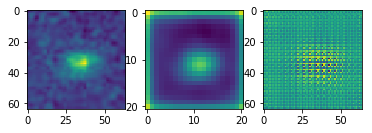

In [108]:
for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        
        img = real_cpu+0.05*torch.rand_like(real_cpu)
        downsampled = F.upsample(img,scale_factor=1/3,mode='bilinear')
        kernel = kernel.to(device)
        img2 = F.conv2d(downsampled, kernel,padding=int(((kernel.shape[3])-1)/2))
        img2 = img2[:,:,:,:]
        
        plt.subplot(1,3,1)
        plt.imshow(real_cpu[1,0,:,:])      
        plt.subplot(1,3,2)
        plt.imshow(img2[1,0,:,:])
        img = netS(img2)
        im = img[1,0,:,:]
        plt.subplot(1,3,3)
        im = im.data.numpy()
        plt.imshow(im)
        stop
        


In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


netG = Generator(ngpu).to(device)
netG.apply(weights_init)
#if netG != '':
#    netG.load_state_dict(torch.load(netG))
print(netG)

In [119]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)


netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
#if netD != '':
#    netD.load_state_dict(torch.load(netD))
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [121]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(batchSize, nz, 1, 1, device=device)
real_label = 1
fake_label = 0

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with resampled, lower res, noise added images

        kernel = kernel.to(device)
        img = F.conv2d(real_cpu, kernel,padding=int(((kernel.shape[3])-1)/2))
        img = img+0.05*torch.rand_like(img)
        img = img[:,:,7:-7,7:-7]
        downsampled = F.upsample(img,scale_factor=1/3,mode='bilinear')
    
        
        downsampled_1d = downsampled.view([batch_size,nz,1,1])
        fake = netG(downsampled_1d)
        label.fill_(fake_label)
        fd = fake.detach()
        output = netD(fd.float())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, niter, i, len(dataloader),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        if i % 100 == 0:
            vutils.save_image(real_cpu,
                    '%s/real_samples.png' % outf,
                    normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.detach(),
                    '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
                    normalize=True)
    # do checkpointing
    torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (outf, epoch))
    torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (outf, epoch))

[0/10][0/95] Loss_D: 1.4696 Loss_G: 20.0036 D(x): 0.5145 D(G(z)): 0.5358 / 0.0001
[0/10][1/95] Loss_D: 9.0122 Loss_G: 11.7399 D(x): 0.9994 D(G(z)): 0.9995 / 0.0000


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/shemmati/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/shemmati/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/shemmati/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/shemmati/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/shemmati/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/Users/shemmati/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/shemmati/

KeyboardInterrupt: 

# ignore below

torch.Size([64, 1, 60, 60])
torch.Size([1, 1, 41, 41])
torch.Size([64, 1, 60, 60])


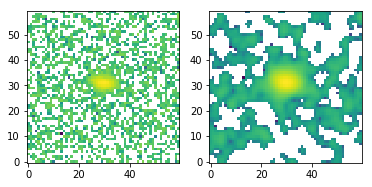

In [5]:
test_im = pyfits.getdata('gal_cutout.fits')
test_im = np.asarray(test_im,dtype=float)
data = np.repeat(test_im[:, :, np.newaxis], batchSize, axis=2)
data = np.repeat(data[:,:,:,np.newaxis],1,axis = 3)
data = torch.Tensor(data)
data = data.permute(2,3,0,1)

output = F.conv2d(data, kernel,padding=int(((kernel.shape[3])-1)/2))

print(data.shape)
print(kernel.shape)
print(output.shape)

convolved = output.data.numpy()
im = convolved[1,0,:,:]
plt.subplot(1,2,1)
plt.imshow(np.log10(test_im),origin='lower')
plt.subplot(1,2,2)
plt.imshow(np.log10(im),origin='lower')

In [23]:
noise = torch.randn(batchSize, nz, 1, 1, device=device)
print(noise.shape)
for i, data in enumerate(dataloader, 0):
    
    img =  data[0].to(device)    
    kernel = kernel.to(device)
    img = F.conv2d(img, kernel,padding=int(((kernel.shape[3])-1)/2))
    img = img+0.01*torch.rand_like(img)
    downsampled = F.upsample(img,scale_factor=0.25,mode='bilinear')
    d = downsampled.view([64,256,1,1])
    stop



torch.Size([64, 256, 1, 1])


NameError: name 'stop' is not defined